# Imputación de valores faltantes

Recordemos que no se puede ignorar los valores faltantes debido a que puede generar sesgos si eliminamos los datos. La imputación nos ayuda a estimar los valores ausentes en base a los valores que tenemos en el dataset

## Importar librerías

In [64]:
import sklearn
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf
import itertools
import upsetplot

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

In [65]:
@pd.api.extensions.register_dataframe_accessor("missing")
class DontMissMe:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def number_missing(self) -> int:
        return self._obj.isna().sum().sum()

    def number_complete(self) -> int:
        return self._obj.size - self._obj.missing.number_missing()

    def missing_variable_summary(self) -> pd.DataFrame:
        return self._obj.isnull().pipe(
            lambda df_1: (
                df_1.sum()
                .reset_index(name="n_missing")
                .rename(columns={"index": "variable"})
                .assign(
                    n_cases=len(df_1),
                    pct_missing=lambda df_2: df_2.n_missing / df_2.n_cases * 100,
                )
            )
        )

    def missing_case_summary(self) -> pd.DataFrame:
        return self._obj.assign(
            case=lambda df: df.index,
            n_missing=lambda df: df.apply(
                axis="columns", func=lambda row: row.isna().sum()
            ),
            pct_missing=lambda df: df["n_missing"] / df.shape[1] * 100,
        )[["case", "n_missing", "pct_missing"]]

    def missing_variable_table(self) -> pd.DataFrame:
        return (
            self._obj.missing.missing_variable_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_variable", 0: "n_variables"})
            .assign(
                pct_variables=lambda df: df.n_variables / df.n_variables.sum() * 100
            )
            .sort_values("pct_variables", ascending=False)
        )

    def missing_case_table(self) -> pd.DataFrame():
        return (
            self._obj.missing.missing_case_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_case", 0: "n_cases"})
            .assign(pct_case=lambda df: df.n_cases / df.n_cases.sum() * 100)
            .sort_values("pct_case", ascending=False)
        )

    def missing_variable_span(self, variable: str, span_every: int) -> pd.DataFrame:
        return (
            self._obj.assign(
                span_counter=lambda df: (
                    np.repeat(a=range(df.shape[0]), repeats=span_every)[: df.shape[0]]
                )
            )
            .groupby("span_counter")
            .aggregate(
                n_in_span=(variable, "size"),
                n_missing=(variable, lambda s: s.isnull().sum()),
            )
            .assign(
                n_complete=lambda df: df.n_in_span - df.n_missing,
                pct_missing=lambda df: df.n_missing / df.n_in_span * 100,
                pct_complete=lambda df: 100 - df.pct_missing,
            )
            .drop(columns=["n_in_span"])
            .reset_index()
        )

    def missing_variable_run(self, variable) -> pd.DataFrame:
        rle_list = self._obj[variable].pipe(
            lambda s: [[len(list(g)), k] for k, g in itertools.groupby(s.isnull())]
        )

        return pd.DataFrame(data=rle_list, columns=["run_length", "is_na"]).replace(
            {False: "complete", True: "missing"}
        )

    def sort_variables_by_missingness(self, ascending=False):

        return self._obj.pipe(
            lambda df: (df[df.isna().sum().sort_values(ascending=ascending).index])
        )

    def create_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
        suffix: str = "_NA",
    ) -> pd.DataFrame:
        return (
            self._obj.isna()
            .pipe(lambda df: df[df.columns[df.any()]] if only_missing else df)
            .replace({False: false_string, True: true_string})
            .add_suffix(suffix)
        )

    def bind_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
        suffix: str = "_NA",
    ) -> pd.DataFrame:
        return pd.concat(
            objs=[
                self._obj,
                self._obj.missing.create_shadow_matrix(
                    true_string=true_string,
                    false_string=false_string,
                    only_missing=only_missing,
                    suffix=suffix,
                ),
            ],
            axis="columns",
        )

    def missing_scan_count(self, search) -> pd.DataFrame:
        return (
            self._obj.apply(axis="rows", func=lambda column: column.isin(search))
            .sum()
            .reset_index()
            .rename(columns={"index": "variable", 0: "n"})
            .assign(original_type=self._obj.dtypes.reset_index()[0])
        )

    # Plotting functions ---

    def missing_variable_plot(self):
        df = self._obj.missing.missing_variable_summary().sort_values("n_missing")

        plot_range = range(1, len(df.index) + 1)

        plt.hlines(y=plot_range, xmin=0, xmax=df.n_missing, color="black")

        plt.plot(df.n_missing, plot_range, "o", color="black")

        plt.yticks(plot_range, df.variable)

        plt.grid(axis="y")

        plt.xlabel("Number missing")
        plt.ylabel("Variable")

    def missing_case_plot(self):

        df = self._obj.missing.missing_case_summary()

        sns.displot(data=df, x="n_missing", binwidth=1, color="black")

        plt.grid(axis="x")
        plt.xlabel("Number of missings in case")
        plt.ylabel("Number of cases")

    def missing_variable_span_plot(
        self, variable: str, span_every: int, rot: int = 0, figsize=None
    ):

        (
            self._obj.missing.missing_variable_span(
                variable=variable, span_every=span_every
            ).plot.bar(
                x="span_counter",
                y=["pct_missing", "pct_complete"],
                stacked=True,
                width=1,
                color=["black", "lightgray"],
                rot=rot,
                figsize=figsize,
            )
        )

        plt.xlabel("Span number")
        plt.ylabel("Percentage missing")
        plt.legend(["Missing", "Present"])
        plt.title(
            f"Percentage of missing values\nOver a repeating span of { span_every } ",
            loc="left",
        )
        plt.grid(False)
        plt.margins(0)
        plt.tight_layout(pad=0)

    def missing_upsetplot(self, variables: list[str] = None, **kwargs):

        if variables is None:
            variables = self._obj.columns.tolist()

        return (
            self._obj.isna()
            .value_counts(variables)
            .pipe(lambda df: upsetplot.plot(df, **kwargs))
        )

    def scatter_imputation_plot(
        self, x, y, imputation_suffix="_imp", show_marginal=False, **kwargs
    ):

        x_imputed = f"{ x }{ imputation_suffix }"
        y_imputed = f"{ y }{ imputation_suffix }"

        plot_func = sns.scatterplot if not show_marginal else sns.jointplot

        return (
            self._obj[[x, y, x_imputed, y_imputed]]
            .assign(is_imputed=lambda df: df[x_imputed] | df[y_imputed])
            .pipe(lambda df: (plot_func(data=df, x=x, y=y, hue="is_imputed", **kwargs)))
        )

    def missing_mosaic_plot(
        self,
        target_var: str,
        x_categorical_var: str,
        y_categorical_var: str,
        ax = None
    ):
        return (
            self._obj
            .assign(
                **{target_var: lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"])}
            )
            .groupby(
                [x_categorical_var, y_categorical_var, target_var],
                dropna=False,
                as_index=True,
            )
            .size()
            .pipe(
                lambda df: mosaic(
                    data=df,
                    properties=lambda key: {"color": "r" if "NA" in key else "gray"},
                    ax=ax,
                    horizontal=True,
                    axes_label=True,
                    title="",
                    labelizer=lambda key: "",
                )
            )
        )


C:\Users\shani\AppData\Local\Temp\ipykernel_2116\1450815642.py:1: UserWarning: registration of accessor <class '__main__.DontMissMe'> under name 'missing' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("missing")


In [66]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (10,10)
    }
)
sns.set_style("whitegrid")

## El problema de valores faltantes

Como se ha mencionado, los algoritmos de machine learning no tiene en cuenta los valores faltantes, por lo que se eliminan cuando se hace un modelo

In [67]:
airquality_df = (
    sm.datasets.get_rdataset('airquality')
    .data
    .clean_names(
        case_type='snake'
    )
    .add_column('year', 1973)
    .assign(
        date=lambda df: pd.to_datetime(df[['year', 'month', 'day']])
    )
    .sort_values(by='date')
    .set_index('date')
)

airquality_df

c:\Users\shani\anaconda3\Lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.assign` instead.
  return method(self._obj, *args, **kwargs)


ozone  solar_r  wind  temp  month  day  year
date                                                    
1973-05-01   41.0    190.0   7.4    67      5    1  1973
1973-05-02   36.0    118.0   8.0    72      5    2  1973
1973-05-03   12.0    149.0  12.6    74      5    3  1973
1973-05-04   18.0    313.0  11.5    62      5    4  1973
1973-05-05    NaN      NaN  14.3    56      5    5  1973
...           ...      ...   ...   ...    ...  ...   ...
1973-09-26   30.0    193.0   6.9    70      9   26  1973
1973-09-27    NaN    145.0  13.2    77      9   27  1973
1973-09-28   14.0    191.0  14.3    75      9   28  1973
1973-09-29   18.0    131.0   8.0    76      9   29  1973
1973-09-30   20.0    223.0  11.5    68      9   30  1973

[153 rows x 7 columns]

In [68]:
airquality_df.isna().sum()

ozone      37
solar_r     7
wind        0
temp        0
month       0
day         0
year        0
dtype: int64

In [69]:
(
    smf.ols(
        formula = "temp ~ ozone",
        data = airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

<class 'statsmodels.iolib.table.SimpleTable'>

In [70]:
(
    smf.ols(
        formula = "temp ~ ozone + solar_r",
        data = airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

<class 'statsmodels.iolib.table.SimpleTable'>

## Limpieza de datos

In [71]:
nhanes_raw_df = (
    nhanes.load.load_NHANES_data(year="2017-2018")
    .clean_names(case_type = "snake")
)
nhanes_raw_df

general_health_condition  ever_breastfed_or_fed_breastmilk  \
SEQN                                                                  
93703.0                       NaN                               1.0   
93704.0                       NaN                               1.0   
93705.0                      Good                               NaN   
93706.0                 Very good                               NaN   
93707.0                      Good                               NaN   
...                           ...                               ...   
102952.0                Very good                               NaN   
102953.0                  Fair or                               NaN   
102954.0                     Good                               NaN   
102955.0                Very good                               NaN   
102956.0                     Good                               NaN   

          age_stopped_breastfeedingdays  age_first_fed_formuladays  \
SEQN                                                                 
93703.0                           273.0                        1.0   
93704.0                            60.0                        3.0   
93705.0                             NaN                        NaN   
93706.0                             NaN                        NaN   
93707.0                             NaN                        NaN   
...                                 ...                        ...   
102952.0                            NaN                        NaN   
102953.0                            NaN                        NaN   
102954.0                            NaN                        NaN   
102955.0                            NaN                        NaN   
102956.0                            NaN                        NaN   

          age_stopped_receiving_formuladays  age_started_other_foodbeverage  \
SEQN                                                                          
93703.0                               365.0                           152.0   
93704.0                               365.0                           126.0   
93705.0                                 NaN                             NaN   
93706.0                                 NaN                             NaN   
93707.0                                 NaN                             NaN   
...                                     ...                             ...   
102952.0                                NaN                             NaN   
102953.0                                NaN                             NaN   
102954.0                                NaN                             NaN   
102955.0                                NaN                             NaN   
102956.0                                NaN                             NaN   

          age_first_fed_milkdays type_of_milk_first_fed_whole_milk  \
SEQN                                                                 
93703.0                    365.0             Whole or regular milk   
93704.0                    365.0             Whole or regular milk   
93705.0                      NaN                               NaN   
93706.0                      NaN                               NaN   
93707.0                      NaN                               NaN   
...                          ...                               ...   
102952.0                     NaN                               NaN   
102953.0                     NaN                               NaN   
102954.0                     NaN                               NaN   
102955.0                     NaN                               NaN   
102956.0                     NaN                               NaN   

          type_of_milk_first_fed2_milk  type_of_milk_first_fed1_milk  ...  \
SEQN                                                                  ...   
93703.0                            NaN                           NaN  ...   
9370

In [72]:
nhanes_df = (
    nhanes_raw_df
    .select_columns(
        "general_health_condition",
        "age_in_years_at_screening",
        "gender",
        "current_selfreported_height_inches",
        "current_selfreported_weight_pounds",
        "doctor_told_you_have_diabetes",
        "60_sec_pulse30_sec_pulse2",
        "total_cholesterol_mgdl"
    )
    .rename(
        {
            'age_in_years_at_screening': 'age',
            'current_selfreported_height_inches': 'height',
            'current_selfreported_weight_pounds': 'weight',
            'doctor_told_you_have_diabetes': 'diabetes',
            '60_sec_pulse30_sec_pulse2': 'pulse',
            'total_cholesterol_mgdl': 'total_cholesterol'
        },
        axis=1
    )
    .replace(
        {
            'height': {
                9999: np.nan,
                7777: np.nan,
            },
            'weight': {
                9999: np.nan,
                7777: np.nan,
            },
            'diabetes': {
                'Borderline': np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness() # Ordenar por faltantes
    .dropna(
        subset = ["diabetes"],
        how = "any"
    )
    .transform_column(
        column_name = 'diabetes',
        function = lambda s: s.astype(int),
        elementwise = False
    )
)
nhanes_df

height  weight general_health_condition  total_cholesterol  pulse  \
SEQN                                                                          
93703.0      NaN     NaN                      NaN                NaN    NaN   
93704.0      NaN     NaN                      NaN                NaN    NaN   
93705.0     63.0   165.0                     Good              157.0   52.0   
93706.0     68.0   145.0                Very good              148.0   82.0   
93707.0      NaN     NaN                     Good              189.0  100.0   
...          ...     ...                      ...                ...    ...   
102951.0     NaN     NaN                      NaN                NaN    NaN   
102953.0    65.0   218.0                  Fair or              182.0   78.0   
102954.0    66.0   150.0                     Good              172.0   78.0   
102955.0     NaN     NaN                Very good              150.0   74.0   
102956.0    69.0   250.0                     Good              163.0   76.0   

          diabetes   age  gender  
SEQN                              
93703.0          0   2.0  Female  
93704.0          0   2.0    Male  
93705.0          0  66.0  Female  
93706.0          0  18.0    Male  
93707.0          0  13.0    Male  
...            ...   ...     ...  
102951.0         0   4.0    Male  
102953.0         0  42.0    Male  
102954.0         0  41.0  Female  
102955.0         0  14.0  Female  
102956.0         0  38.0    Male  

[8187 rows x 8 columns]

## Visualización de datos

<Axes: >

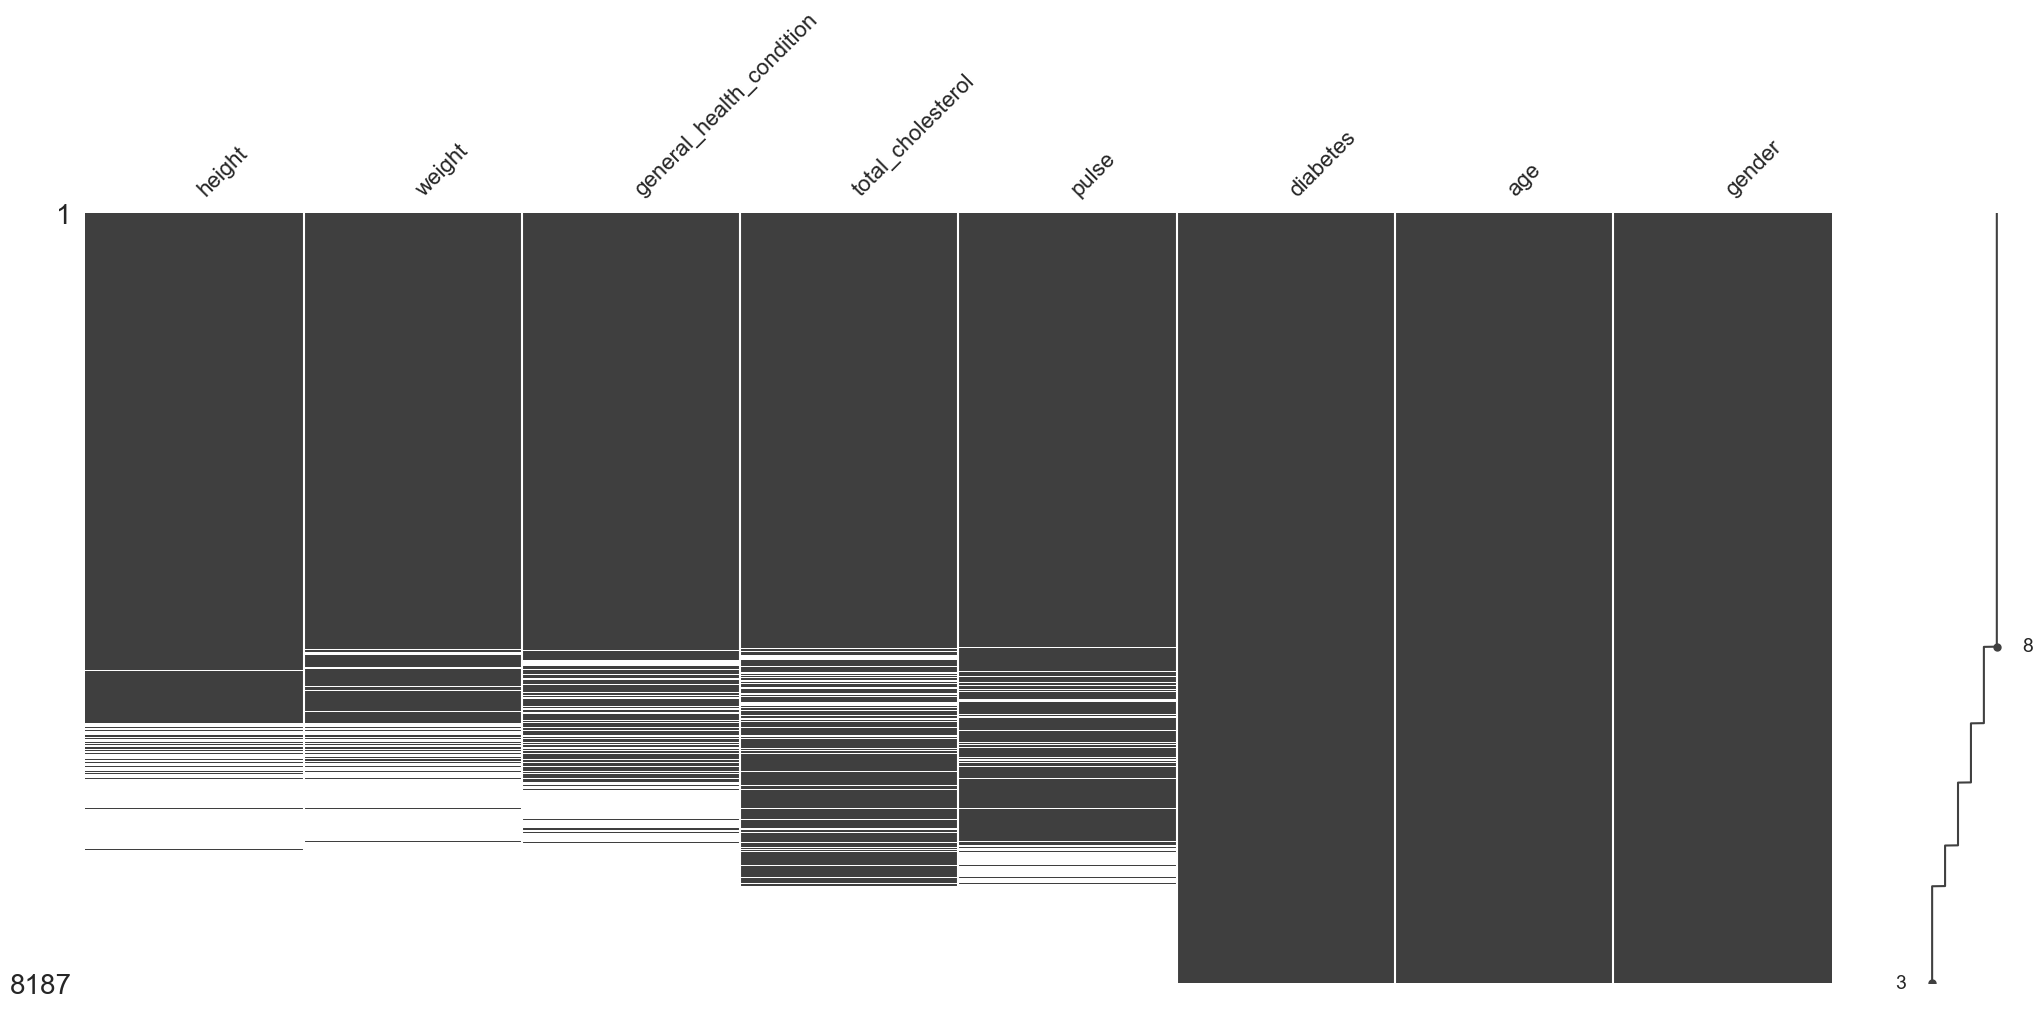

In [73]:
(
    nhanes_df
    .pipe(missingno.matrix, sort="descending")
)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

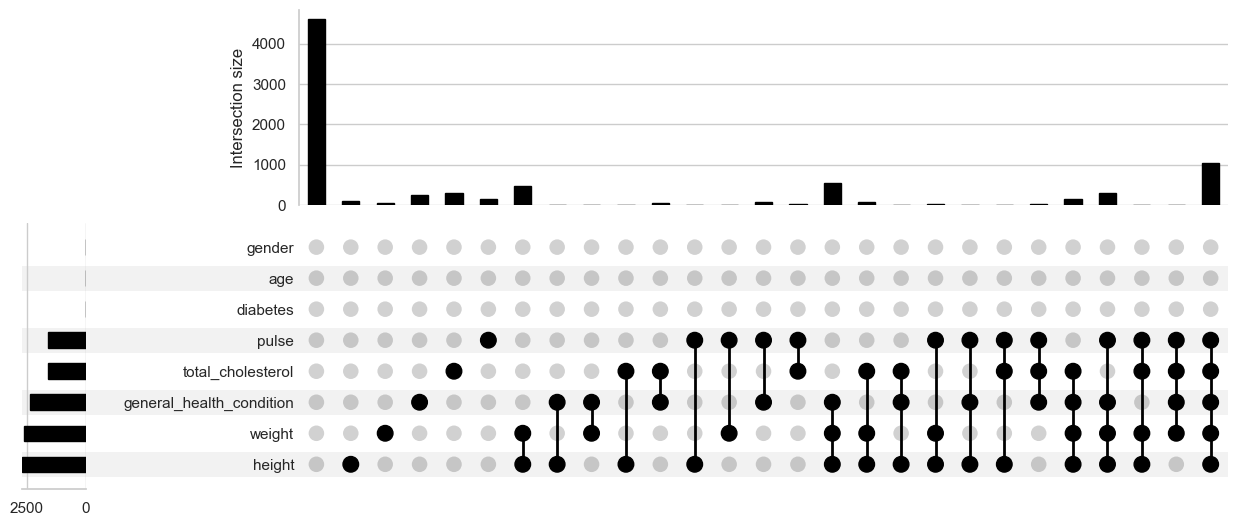

In [74]:
(
    nhanes_df
    .missing.missing_upsetplot()
)

Observamos en la gráfica anterior que hay aproximadamente 1000 valores con 5 columnas faltantes

<Axes: >

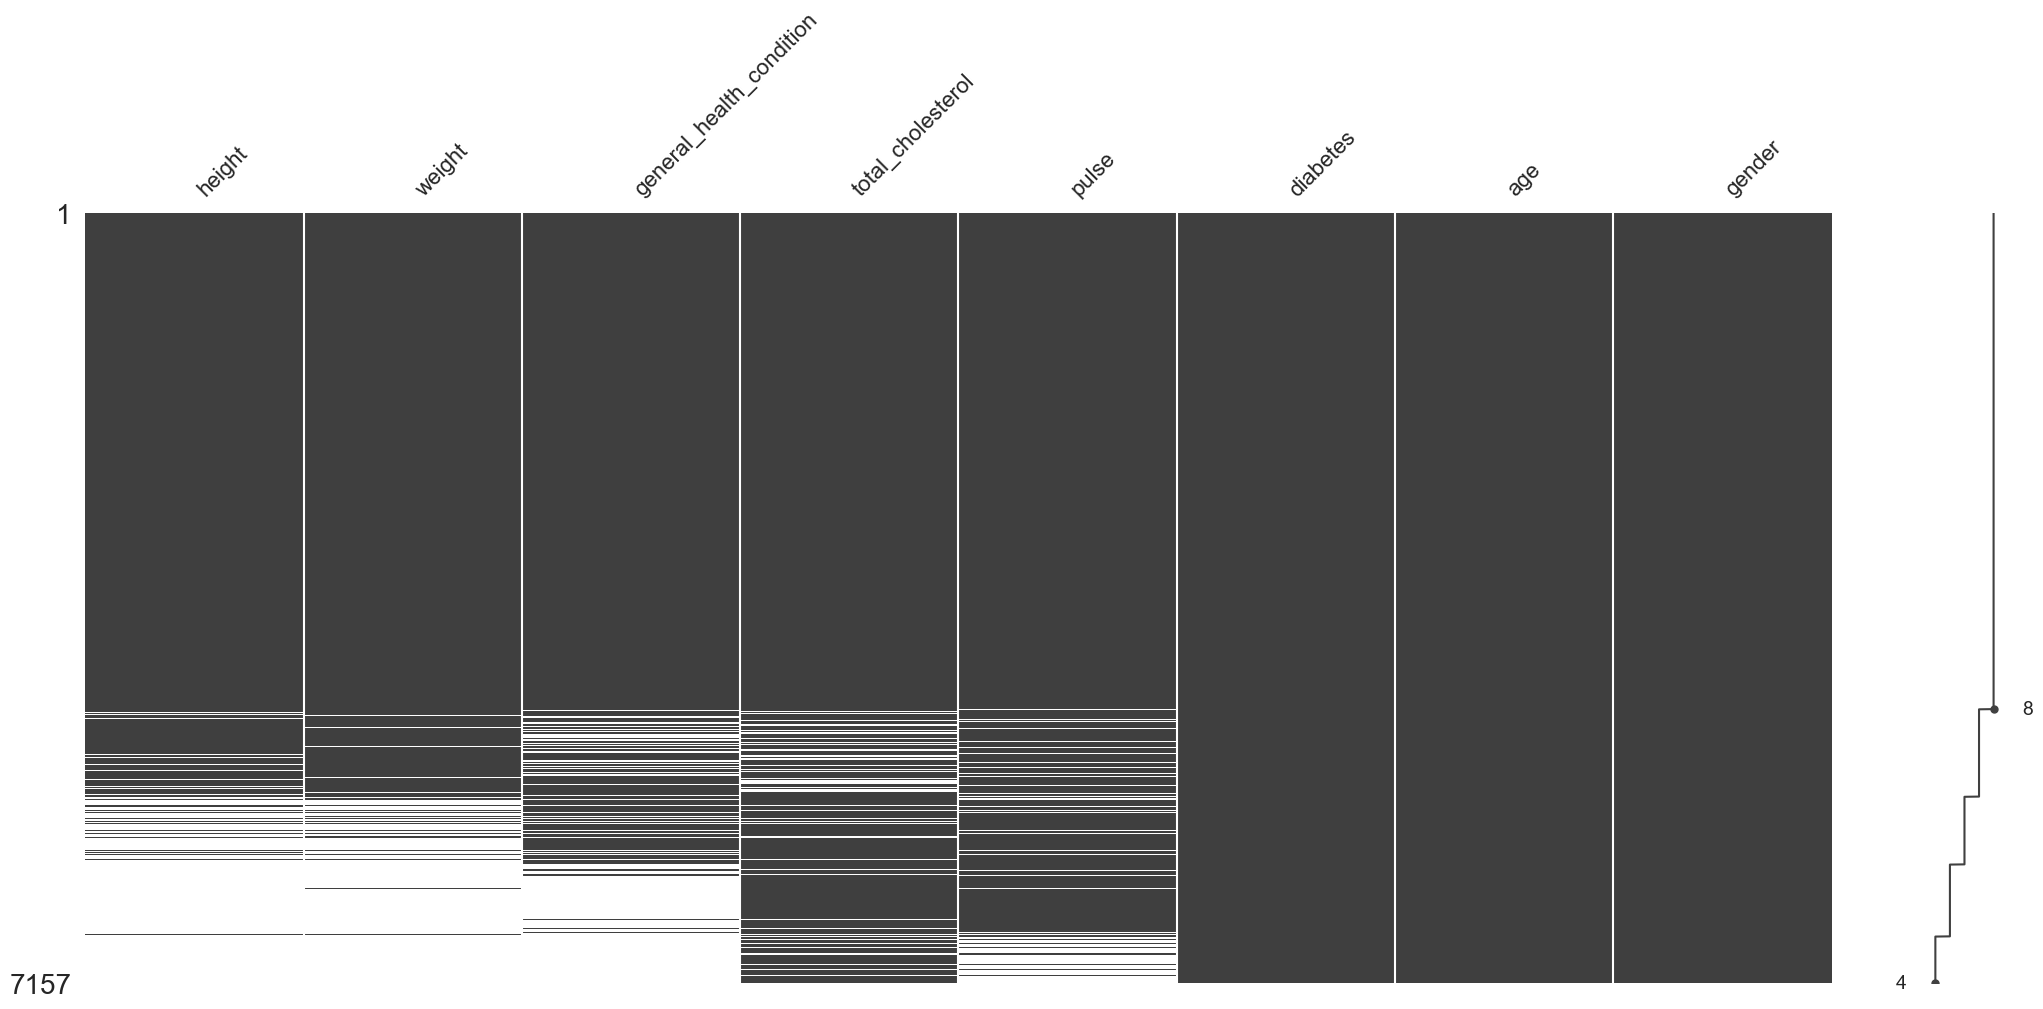

In [75]:
nhanes_df = (
    nhanes_df
    .dropna(
        subset = ["pulse", "total_cholesterol", "general_health_condition", "weight", "height"],
        how = "all"
    )
    .missing.sort_variables_by_missingness()
)
nhanes_df.pipe(missingno.matrix, sort="descending")

## Mecanismos

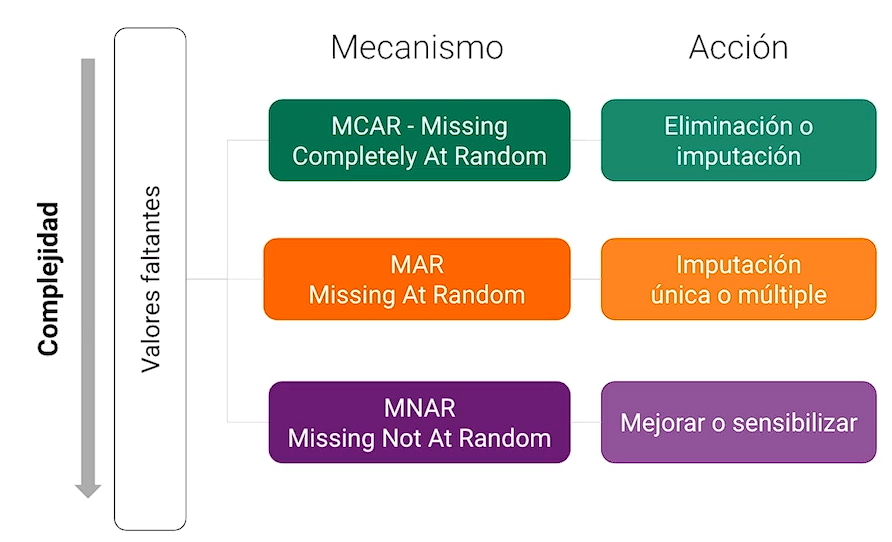

Se evaluan con t-test

In [76]:
female_weight, male_weight = (
    nhanes_df
    .select_columns("gender","weight")
    .transform_column(
        "weight",
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby("gender")
    .weight
    .pipe(
        lambda df:(
            df.get_group("Female"),
            df.get_group("Male")
        )
    )
)

female_weight, male_weight

(SEQN
 93705.0     False
 93709.0     False
 93714.0     False
 93719.0      True
 93721.0     False
             ...  
 102941.0     True
 102943.0    False
 102948.0    False
 102954.0    False
 102955.0     True
 Name: weight, Length: 3665, dtype: bool,
 SEQN
 93706.0     False
 93707.0      True
 93711.0     False
 93712.0     False
 93713.0     False
             ...  
 102946.0    False
 102947.0    False
 102949.0    False
 102953.0    False
 102956.0    False
 Name: weight, Length: 3492, dtype: bool)

In [77]:
# NO existe una diferencia en la medición dado el género
scipy.stats.ttest_ind(female_weight, male_weight, alternative="two-sided")

TtestResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239, df=7155.0)

El argumento alternative especifica el tipo de hipótesis nula a probar, en este caso "two-sided" indica que se está realizando una prueba two-tailed, es decir, se está investigando si existe una diferencia significativa entre las dos medias, sin importar en qué dirección.

El resultado es el valor estadístico y el valor p del test t-test independiente entre dos grupos "female_weight" y "male_weight". La hipótesis nula es que la media de ambos grupos es igual.

El valor p obtenido es de 0.717, lo que sugiere que no hay suficiente evidencia para rechazar la hipótesis nula. Por lo tanto, no se puede concluir que la media de los dos grupos sea diferente.

El valor absoluto del estadístico t, 0.362, es bajo, lo que indica que las diferencias entre los dos grupos son poco significativas.

## Ampliar herramientas para explorar datos faltantes

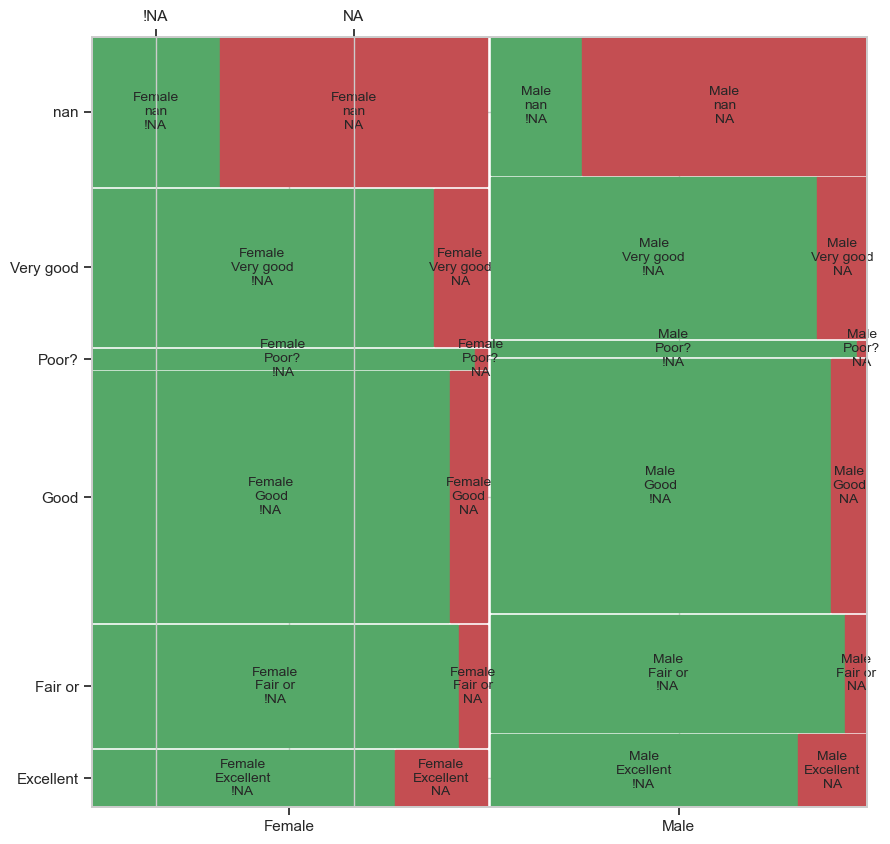

In [78]:
(
    nhanes_df
    .select_columns("weight", "general_health_condition", "gender")
    .assign(
        weight = lambda df: df["weight"].isna().replace([True, False], ["NA", "!NA"])
    )
    .groupby(
        ["gender", "general_health_condition", "weight"],
        dropna=False,
        as_index = True
    )
    .size()
    .pipe(
        lambda df:(
            mosaic(
                df,
                properties = lambda key: {"color": "r" if "NA" in key else "g"},
                horizontal = True,
                axes_label = True,
                title = "",
                # labelizer = lambda key: ""
            )
        )
    )
);

## Tratamiento de variables categóricas


In [79]:
nhanes_transformed_df = nhanes_df.copy(deep=True)

### Codificación ordinal

Implica mapear la etiqueta a un valor entero, se utiliza cuando existe un orden o jerarquía natural entre las categorías de una variable categórica. Esto significa que las categorías tienen una relación de orden y se pueden asignar valores numéricos que reflejen este orden. Algunos ejemplos de variables categóricas donde se puede aplicar el OrdinalEncoder son:

Niveles de educación: como "Primaria", "Secundaria", "Universidad", donde hay un orden lógico de menor a mayor nivel educativo.

Evaluaciones de rendimiento: como "Bajo", "Medio", "Alto", donde hay una escala ordinal de bajo a alto rendimiento.


In [80]:
X = [["Male"], ["Female"], ["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [81]:
encoder = sklearn.preprocessing.OrdinalEncoder()
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [82]:
# Ver todas las categorías
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [83]:
encoder.inverse_transform([[1], [0], [0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

#### Aplicandolo a la base de datos

In [84]:
catecorical_columns = nhanes_df.select_dtypes(include=[object, "category"]).columns
catecorical_columns

Index(['general_health_condition', 'gender'], dtype='object')

In [85]:
catecorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), catecorical_columns), # Que transformador usar
    remainder="passthrough" # Decidir que hacer con las otras variables del df
)

In [86]:
nhanes_transformed_df = (
    pd.DataFrame(
        catecorical_transformer.fit_transform(nhanes_df),
        columns=catecorical_transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename(
        mapper = lambda x: x.removeprefix("ordinalencoder__"),
        axis = 1
    )
    .rename(
        mapper = lambda x: x.removeprefix("remainder__"),
        axis = 1
    )
)
nhanes_transformed_df

general_health_condition  gender  height  weight  total_cholesterol  \
SEQN                                                                            
93705.0                        2.0     0.0    63.0   165.0              157.0   
93706.0                        4.0     1.0    68.0   145.0              148.0   
93707.0                        2.0     1.0     NaN     NaN              189.0   
93709.0                        NaN     0.0    62.0   200.0              176.0   
93711.0                        4.0     1.0    69.0   142.0              238.0   
...                            ...     ...     ...     ...                ...   
102949.0                       0.0     1.0    72.0   180.0              201.0   
102953.0                       1.0     1.0    65.0   218.0              182.0   
102954.0                       2.0     0.0    66.0   150.0              172.0   
102955.0                       4.0     0.0     NaN     NaN              150.0   
102956.0                       2.0     1.0    69.0   250.0              163.0   

          pulse  diabetes   age  
SEQN                             
93705.0    52.0       0.0  66.0  
93706.0    82.0       0.0  18.0  
93707.0   100.0       0.0  13.0  
93709.0    74.0       0.0  75.0  
93711.0    62.0       0.0  56.0  
...         ...       ...   ...  
102949.0   96.0       0.0  33.0  
102953.0   78.0       0.0  42.0  
102954.0   78.0       0.0  41.0  
102955.0   74.0       0.0  14.0  
102956.0   76.0       0.0  38.0  

[7157 rows x 8 columns]

In [87]:
gender_encoder = sklearn.preprocessing.OrdinalEncoder()

gender_values = (
    nhanes_df
    .gender
    .values
    .reshape(-1, 1)
)
(
    gender_encoder
    .fit_transform(
        gender_values
    )
    .squeeze()
)

(
    nhanes_df.gender.unique(),
    nhanes_transformed_df.gender.unique(),
    gender_encoder.categories_
)

(array(['Female', 'Male'], dtype=object),
 array([0., 1.]),
 [array(['Female', 'Male'], dtype=object)])

### One-hot coding

Es una matriz donde cada columna corresponde a cada categoría, se utiliza cuando no existe un orden o jerarquía natural entre las categorías de una variable categórica, y se desea crear variables binarias para cada categoría. Esto permite representar cada categoría como una columna independiente, donde un valor de 1 indica la presencia de esa categoría y un valor de 0 indica la ausencia. Algunos ejemplos de variables categóricas donde se puede aplicar el OneHotEncoder son:

Colores: como "Rojo", "Verde", "Azul", donde cada color se representa como una columna separada en el conjunto de datos codificado en caliente.

Países: como "Estados Unidos", "Canadá", "México", donde cada país se representa como una columna separada indicando su presencia o ausencia.

In [88]:
nhanes_transformed_df2 = nhanes_df.copy()

#### Pandas

In [89]:
(
    nhanes_transformed_df2
    .select_columns("general_health_condition")
    .pipe(pd.get_dummies)
)

general_health_condition_Excellent  \
SEQN                                           
93705.0                                False   
93706.0                                False   
93707.0                                False   
93709.0                                False   
93711.0                                False   
...                                      ...   
102949.0                                True   
102953.0                               False   
102954.0                               False   
102955.0                               False   
102956.0                               False   

          general_health_condition_Fair or  general_health_condition_Good  \
SEQN                                                                        
93705.0                              False                           True   
93706.0                              False                          False   
93707.0                              False                           True   
93709.0                              False                          False   
93711.0                              False                          False   
...                                    ...                            ...   
102949.0                             False                          False   
102953.0                              True                          False   
102954.0                             False                           True   
102955.0                             False                          False   
102956.0                             False                           True   

          general_health_condition_Poor?  general_health_condition_Very good  
SEQN                                                                          
93705.0                            False                               False  
93706.0                            False                                True  
93707.0                            False                               False  
93709.0                            False                               False  
93711.0                            False                                True  
...                                  ...                                 ...  
102949.0                           False                               False  
102953.0                           False                               False  
102954.0                           False                               False  
102955.0                           False                                True  
102956.0                           False                               False  

[7157 rows x 5 columns]

#### Sklearn

In [90]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]),
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    remainder="passthrough"
)

In [91]:
nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns=transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename(
        mapper = lambda x: x.removeprefix("ordinalencoder__"),
        axis = 1
    )
    .rename(
        mapper = lambda x: x.removeprefix("remainder__"),
        axis = 1
    )
    .rename(
        mapper = lambda x: x.removeprefix("onehotencoder__"),
        axis = 1
    )
)
nhanes_transformed_df2

gender  general_health_condition_Excellent  \
SEQN                                                   
93705.0      0.0                                 0.0   
93706.0      1.0                                 0.0   
93707.0      1.0                                 0.0   
93709.0      0.0                                 0.0   
93711.0      1.0                                 0.0   
...          ...                                 ...   
102949.0     1.0                                 1.0   
102953.0     1.0                                 0.0   
102954.0     0.0                                 0.0   
102955.0     0.0                                 0.0   
102956.0     1.0                                 0.0   

          general_health_condition_Fair or  general_health_condition_Good  \
SEQN                                                                        
93705.0                                0.0                            1.0   
93706.0                                0.0                            0.0   
93707.0                                0.0                            1.0   
93709.0                                0.0                            0.0   
93711.0                                0.0                            0.0   
...                                    ...                            ...   
102949.0                               0.0                            0.0   
102953.0                               1.0                            0.0   
102954.0                               0.0                            1.0   
102955.0                               0.0                            0.0   
102956.0                               0.0                            1.0   

          general_health_condition_Poor?  general_health_condition_Very good  \
SEQN                                                                           
93705.0                              0.0                                 0.0   
93706.0                              0.0                                 1.0   
93707.0                              0.0                                 0.0   
93709.0                              0.0                                 0.0   
93711.0                              0.0                                 1.0   
...                                  ...                                 ...   
102949.0                             0.0                                 0.0   
102953.0                             0.0                                 0.0   
102954.0                             0.0                                 0.0   
102955.0                             0.0                                 1.0   
102956.0                             0.0                                 0.0   

          general_health_condition_nan  height  weight  total_cholesterol  \
SEQN                                                                        
93705.0                            0.0    63.0   165.0              157.0   
93706.0                            0.0    68.0   145.0              148.0   
93707.0                            0.0     NaN     NaN              189.0   
93709.0                            1.0    62.0   200.0              176.0   
93711.0                            0.0    69.0   142.0              238.0   
...                                ...     ...     ...                ...   
102949.0                           0.0    72.0   180.0              201.0   
102953.0                           0.0    65.0   218.0              182.0   
102954.0                           0.0    66.0   150.0              172.0   
102955.0                           0.0     NaN     NaN              150.0   
102956.0                           0.0    69.0   250.0              163.0   

          pulse  diabetes   age  
SEQN                             
93705.0    52.0       0.0  66.0  
93706.0    82.0       0.0  18.0  
93707.0   100.0       0.0  13.0  
93709.0    74.0       0.0  75.0  
93711.0    62.0       0.0  56.0 

In [92]:
transformer.named_transformers_

{'ordinalencoder': OrdinalEncoder(),
 'onehotencoder': OneHotEncoder(),
 'remainder': 'passthrough'}

In [93]:
transformer.named_transformers_["onehotencoder"].categories_

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [94]:
transformer.named_transformers_["onehotencoder"].inverse_transform(
    X = [[0, 0, 1, 0, 0, 0]]
)

array([['Good']], dtype=object)

## Métodos de imputación de valores faltantes

![image](https://static.platzi.com/media/user_upload/Untitled%20%289%29-66e907a8-22c4-4779-b4c1-a5f557ae1c71.jpg)

Existe otra forma de de clasificar los metodos de imputacion y es a traves de definir si son metodos de imputacion basados en Donantes o en Modelos.

**¿Que son las imputaciones basadas en Donantes?**
Completa los valores que faltan para una unidad dada copiando los valores observados de otra unidad, el donante

**¿Que son las imputaciones con base en Modelos?**
El objetivo es encontrar un modelo predictivo para cada variable objetivo en el conjunto de datos que contiene valores faltantes

### De media, mediana y moda

|Contras   |Pros   |
|---|---|
|Puede sesgar los resultados debido a que modifica la distribución por debajo (curtosis)  |  Rápido y fácil |
|Pierde correlaciones entre variables. No es muy preciso   |La media puede ser útil en presencia de outliers   |
|No puede usar variables categóricas (a exepción de la moda)   |No afectará el estadístico en cuestión ni el tamaño de muestra   |


In [95]:
nhanes_df

height  weight general_health_condition  total_cholesterol  pulse  \
SEQN                                                                          
93705.0     63.0   165.0                     Good              157.0   52.0   
93706.0     68.0   145.0                Very good              148.0   82.0   
93707.0      NaN     NaN                     Good              189.0  100.0   
93709.0     62.0   200.0                      NaN              176.0   74.0   
93711.0     69.0   142.0                Very good              238.0   62.0   
...          ...     ...                      ...                ...    ...   
102949.0    72.0   180.0                Excellent              201.0   96.0   
102953.0    65.0   218.0                  Fair or              182.0   78.0   
102954.0    66.0   150.0                     Good              172.0   78.0   
102955.0     NaN     NaN                Very good              150.0   74.0   
102956.0    69.0   250.0                     Good              163.0   76.0   

          diabetes   age  gender  
SEQN                              
93705.0          0  66.0  Female  
93706.0          0  18.0    Male  
93707.0          0  13.0    Male  
93709.0          0  75.0  Female  
93711.0          0  56.0    Male  
...            ...   ...     ...  
102949.0         0  33.0    Male  
102953.0         0  42.0    Male  
102954.0         0  41.0  Female  
102955.0         0  14.0  Female  
102956.0         0  38.0    Male  

[7157 rows x 8 columns]

In [96]:
def get_stats(df = nhanes_df, column = "height"):
    print(f"Media:{df[column].median()}")
    print(f"Mediana:{df[column].mean()}")
    print(f"Moda{df[column].mode()}")

In [97]:
get_stats()

Media:66.0
Mediana:66.25655976676384
Moda0    66.0
Name: height, dtype: float64


In [98]:
(
    nhanes_df
    .transform_column(
        "height",
        lambda x: x.fillna(x.mean()),
        elementwise = False # Que no se aplique a todos los valores
    )
    .pipe(
        get_stats
    )
)

Media:66.25655976676384
Mediana:66.25655976676386
Moda0    66.25656
Name: height, dtype: float64


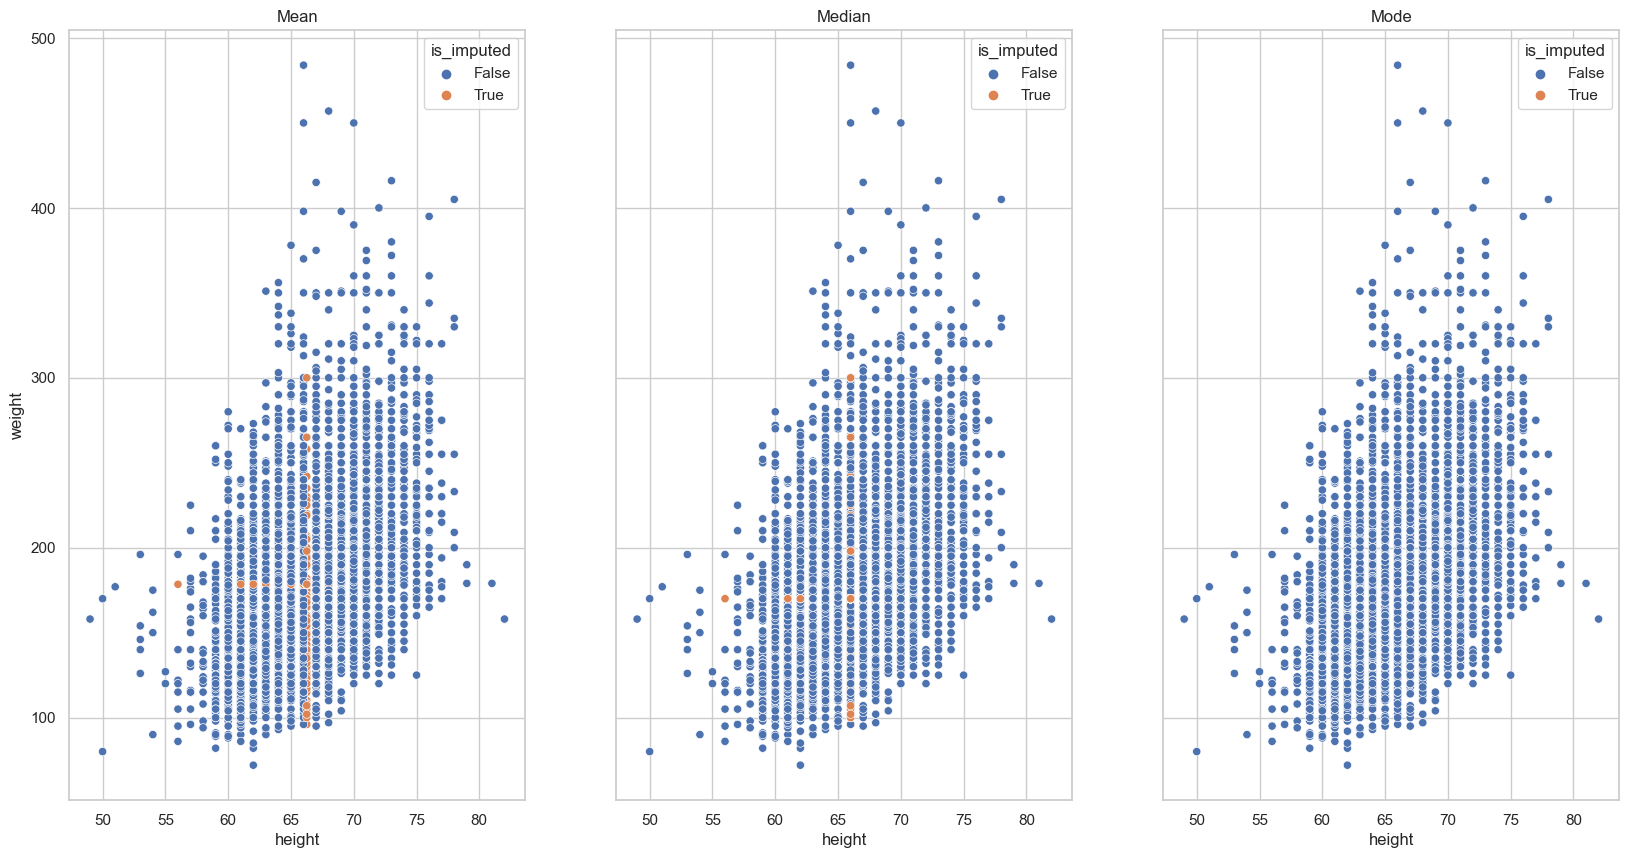

In [99]:
fig, ax = plt.subplots(1,3,figsize=(20,10), sharey=True)

(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean()),
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        ax=ax[0]
    )
)
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.median()),
        weight = lambda df: df.weight.fillna(value = df.weight.median()),
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        ax=ax[1]
    )
)

(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mode()),
        weight = lambda df: df.weight.fillna(value = df.weight.mode()),
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        ax=ax[2]
    )
)

ax[0].set_title("Mean")
ax[1].set_title("Median")
ax[2].set_title("Mode")
plt.show()

### Hacia atrás y hacia adelante

Se repite el valor de arriba o el de abajo hasta completar datos

|Contras   |Pros   |
|---|---|
|Relaciones multivariables pueden ser distorsionadas   |Rápido y fácil   |
|   |Los datos imputados no son constantes   |
|   |Existen trucos para evitar romper las relaciones   |


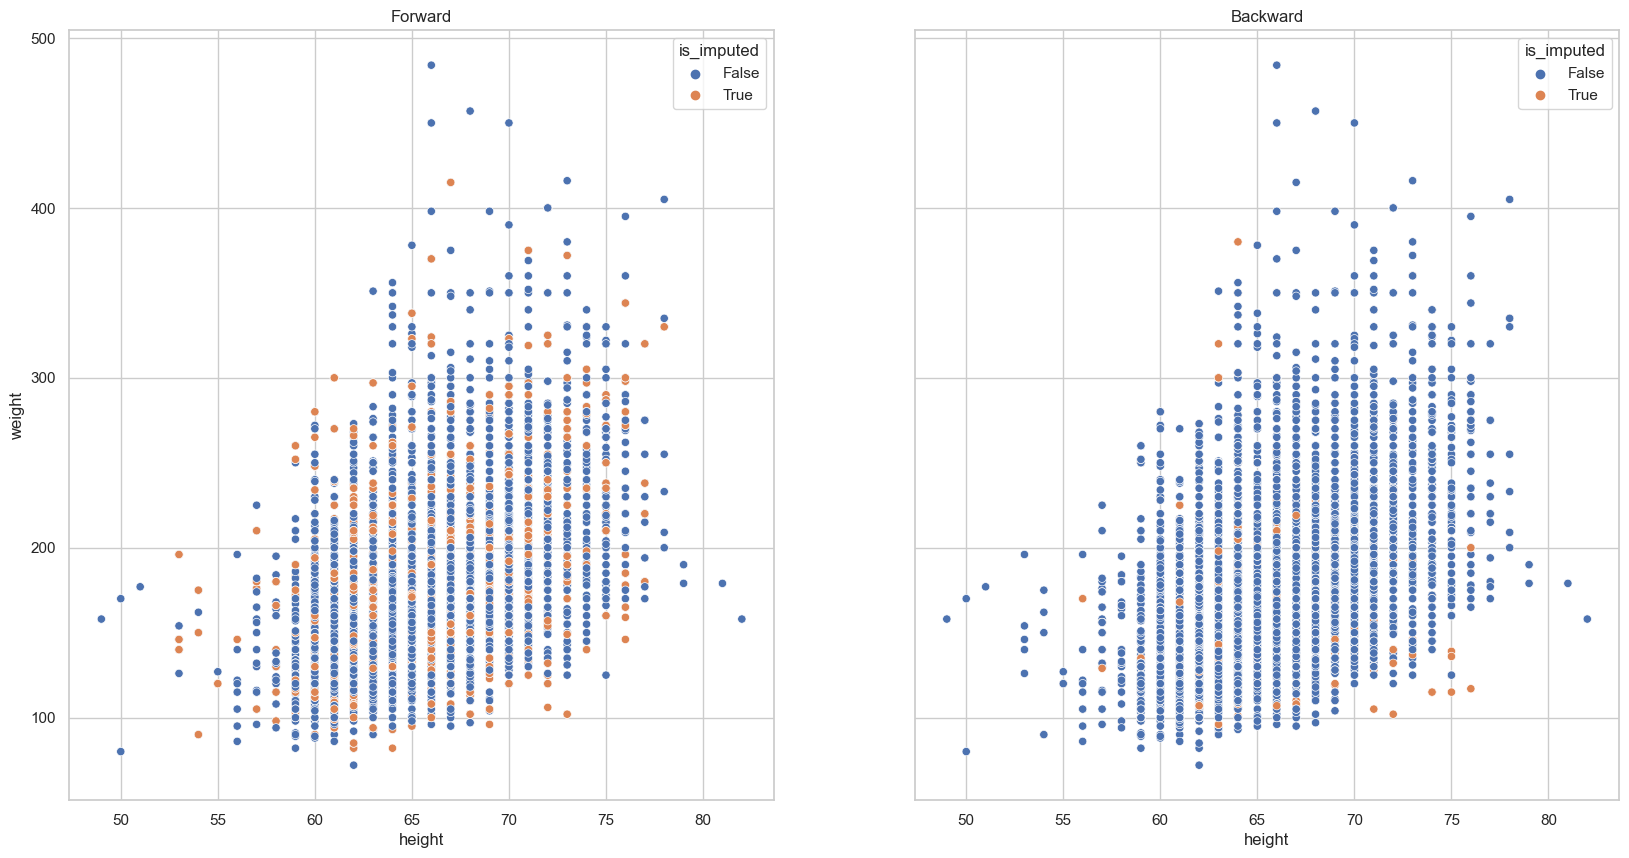

In [100]:
fig, ax = plt.subplots(1,2, figsize=(20,10), sharey=True)

(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    # .fillna(method = "ffill") # Forward
    .ffill()
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        ax=ax[0]
    )
)

(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    # .fillna(method = "bfill") # Backward
    .bfill()
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        ax=ax[1]
    )
)

ax[0].set_title("Forward")
ax[1].set_title("Backward")
plt.show()

#### Recomendaciones

- Imputar dentro de los dominios

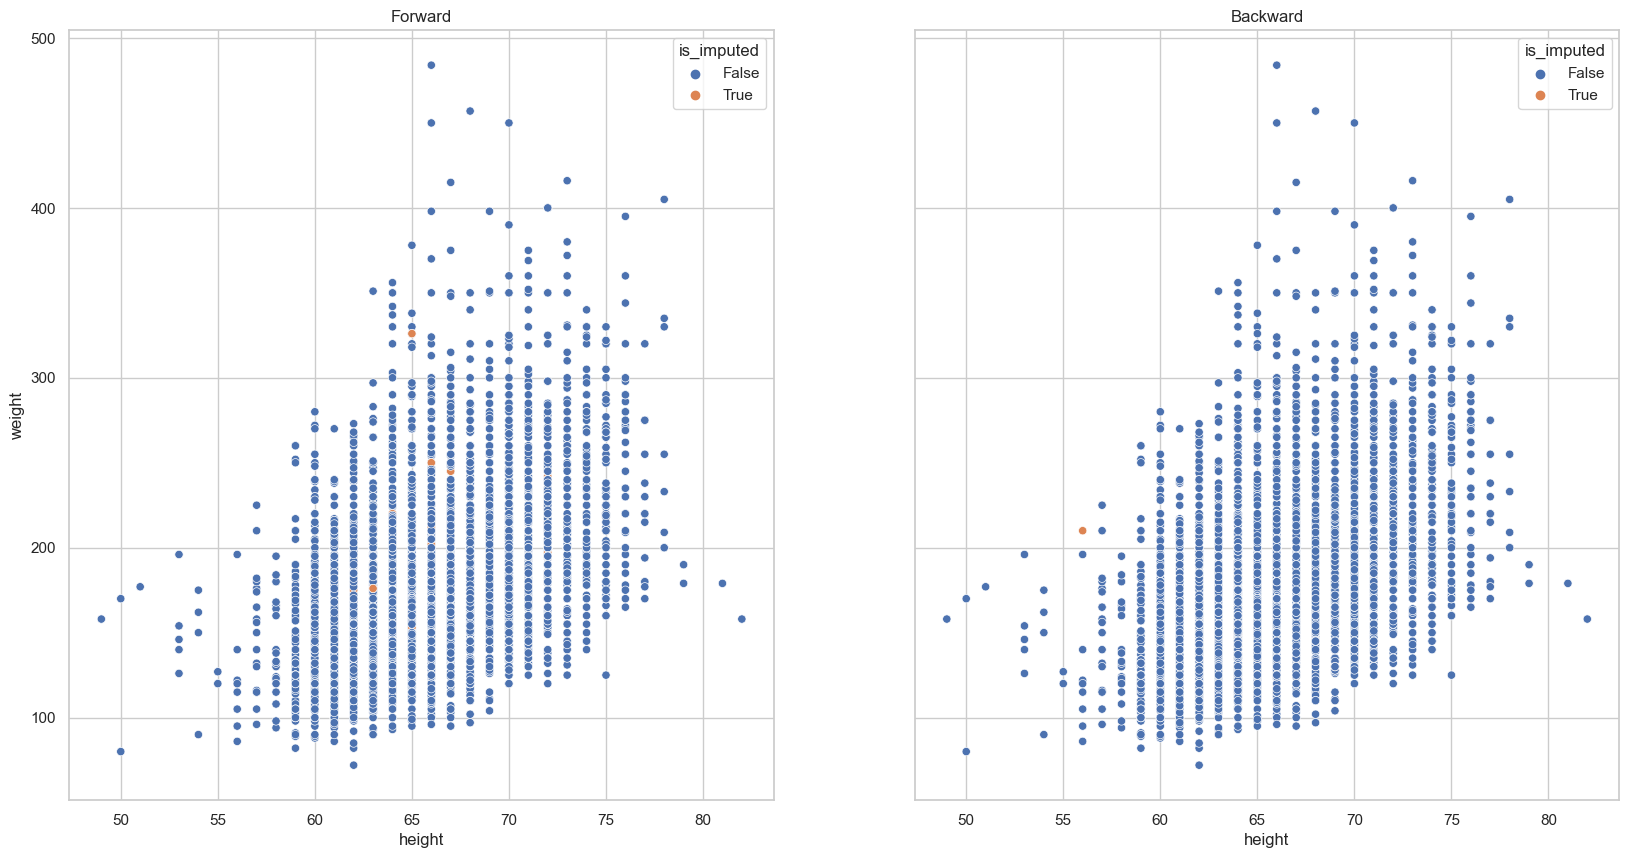

In [101]:
fig, ax = plt.subplots(1,2, figsize=(20,10), sharey=True)

(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by=["gender", "diabetes", "general_health_condition", "height"],
        ascending=True
    )
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    # .fillna(method = "ffill") # Forward
    .transform_column(
        "weight",
        lambda x: x.ffill(),
        elementwise=False
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        ax=ax[0]
    )
)


(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by=["gender", "diabetes", "general_health_condition", "height"],
        ascending=True
    )
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    # .fillna(method = "bfill") # Backward
    .transform_column(
        "weight",
        lambda x: x.bfill(),
        elementwise=False
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        ax=ax[1]
    )
)

ax[0].set_title("Forward")
ax[1].set_title("Backward")
plt.show()

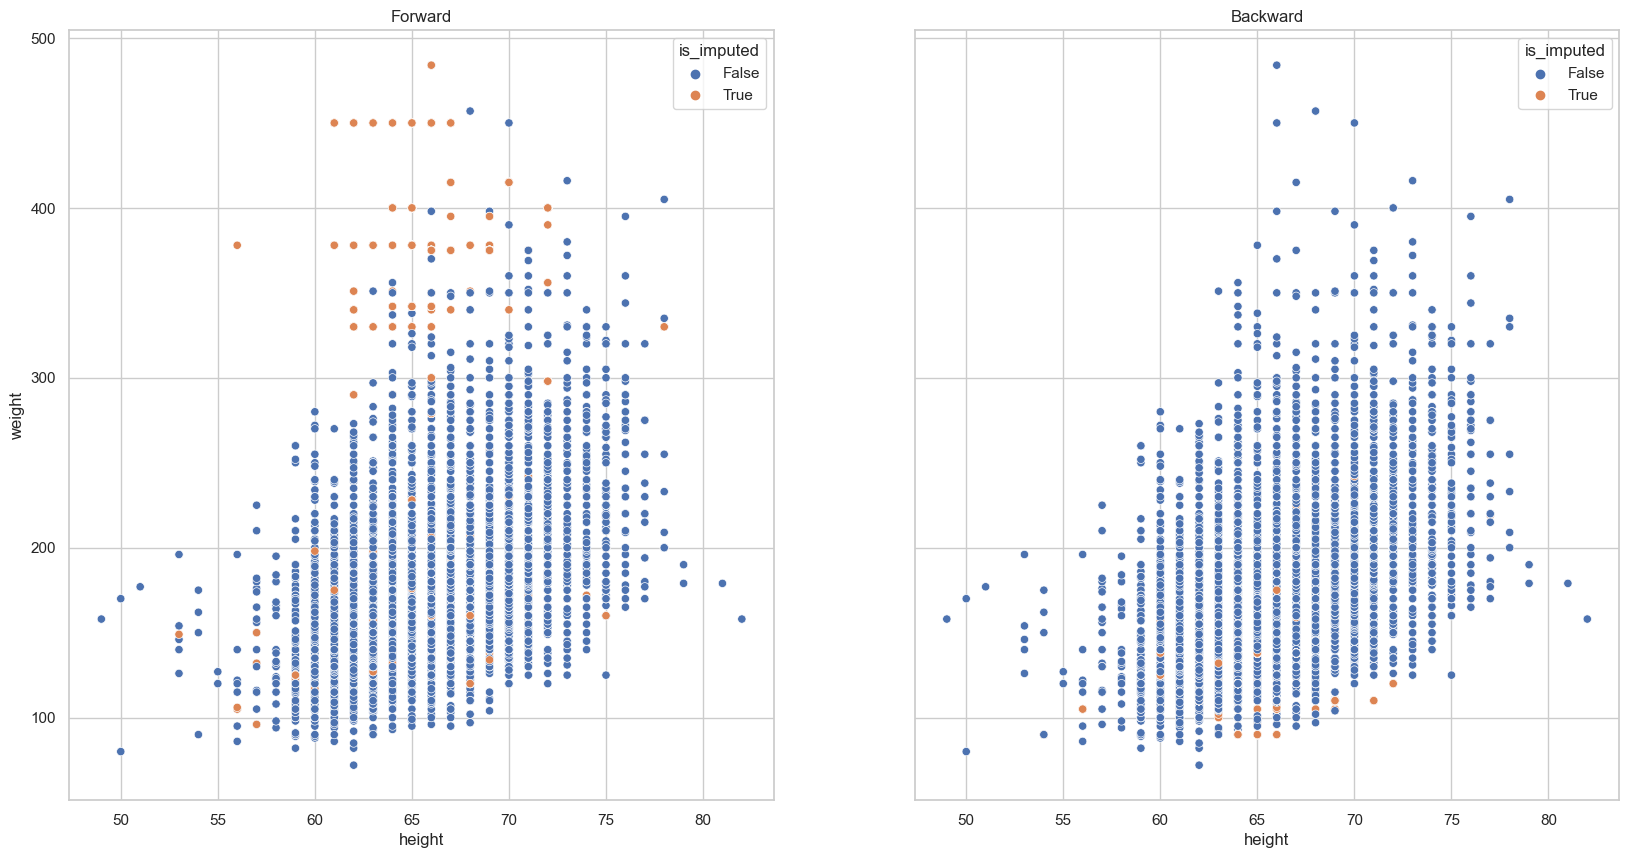

In [102]:
fig, ax = plt.subplots(1,2, figsize=(20,10), sharey=True)

(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by=['gender','diabetes','general_health_condition','weight'],
        ascending=True
    )
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .groupby(["gender", "general_health_condition"], dropna=False)
    .apply(lambda x: x.ffill())
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        ax=ax[0]
    )
)

(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by=['gender','diabetes','general_health_condition','weight'],
        ascending=True
    )
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .groupby(["gender", "general_health_condition"], dropna=False)
    .apply(lambda x: x.bfill())
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        ax=ax[1]
    )
)


ax[0].set_title("Forward")
ax[1].set_title("Backward")
plt.show()

### Por interpolación

Se estiman los puntos desconocidos a partir de los conocidos

|Contras   |Pros   |
|---|---|
|Puede romper relaciones entre variables   |Sencillo de implementar   |
| Puede introducir valores fuera de rango  |Util para series de tiempo   |
|   |Variabilidad de opciones al alcance   |


<Axes: xlabel='date'>

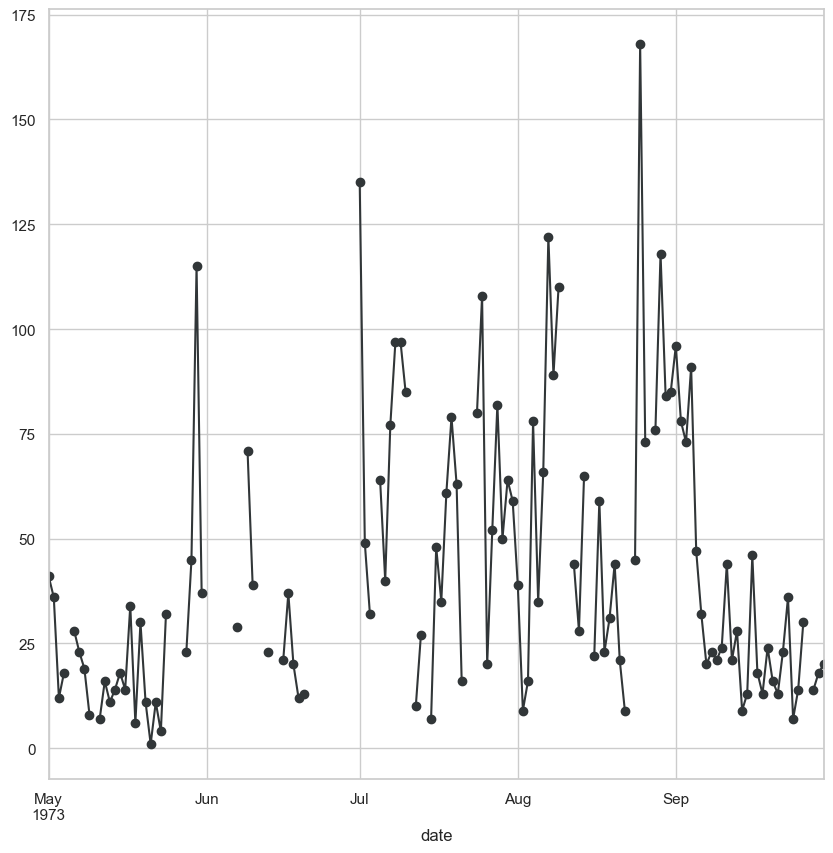

In [103]:
(
    airquality_df
    .select_columns("ozone")
    .pipe(lambda df: df["ozone"].plot(color = "#313638", marker = "o"))
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>, <Axes: xlabel='date'>)

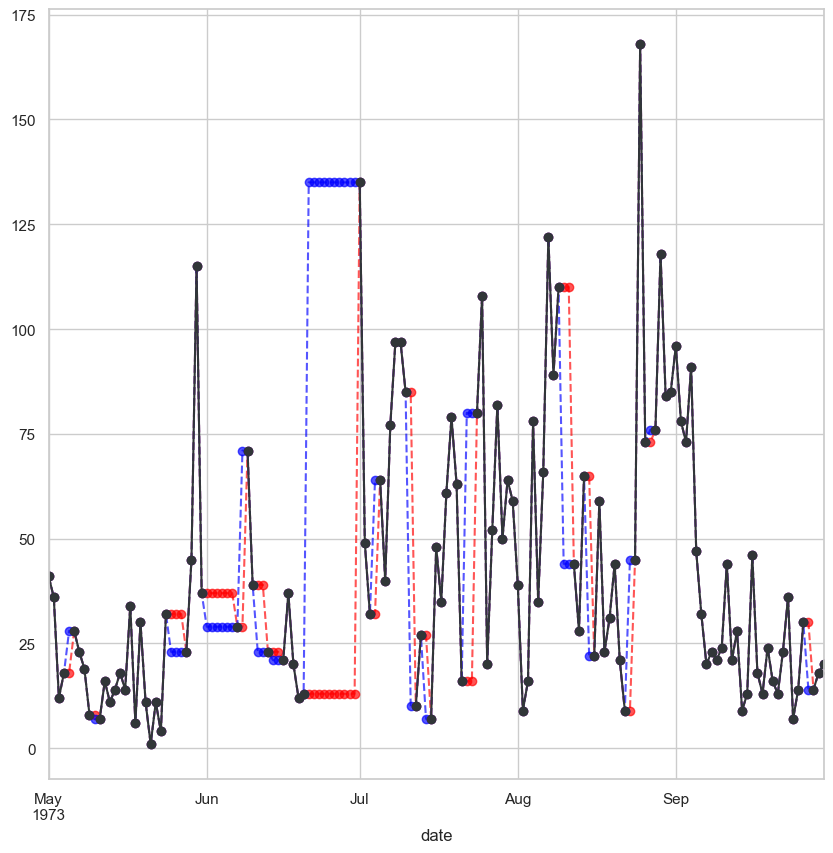

In [104]:

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df["ozone"].ffill().plot(color = "red", marker = "o", alpha = 6/9, linestyle = "dashed"),
            df["ozone"].bfill().plot(color = "blue", marker = "o", alpha = 6/9, linestyle = "dashed"),
            df["ozone"].plot(color = "#313638", marker = "o")
        )
    )
)


In [105]:
modes = ['linear', 'time', 'index', 'values', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'barycentric', 'krogh', 'spline', 'polynomial', 'from_derivatives', 'piecewise_polynomial', 'pchip', 'akima', 'cubicspline']
len(modes)

18

c:\Users\shani\anaconda3\Lib\site-packages\scipy\interpolate\_polyint.py:427: UserWarning: 116 degrees provided, degrees higher than about thirty cause problems with numerical instability with 'KroghInterpolator'
  P = KroghInterpolator(xi, yi, axis=axis)
c:\Users\shani\anaconda3\Lib\site-packages\scipy\interpolate\_polyint.py:335: RuntimeWarning: overflow encountered in multiply
  pi = w*pi
c:\Users\shani\anaconda3\Lib\site-packages\scipy\interpolate\_polyint.py:336: RuntimeWarning: invalid value encountered in add
  p += pi[:,np.newaxis] * self.c[k]
c:\Users\shani\anaconda3\Lib\site-packages\scipy\interpolate\_polyint.py:336: RuntimeWarning: invalid value encountered in multiply
  p += pi[:,np.newaxis] * self.c[k]


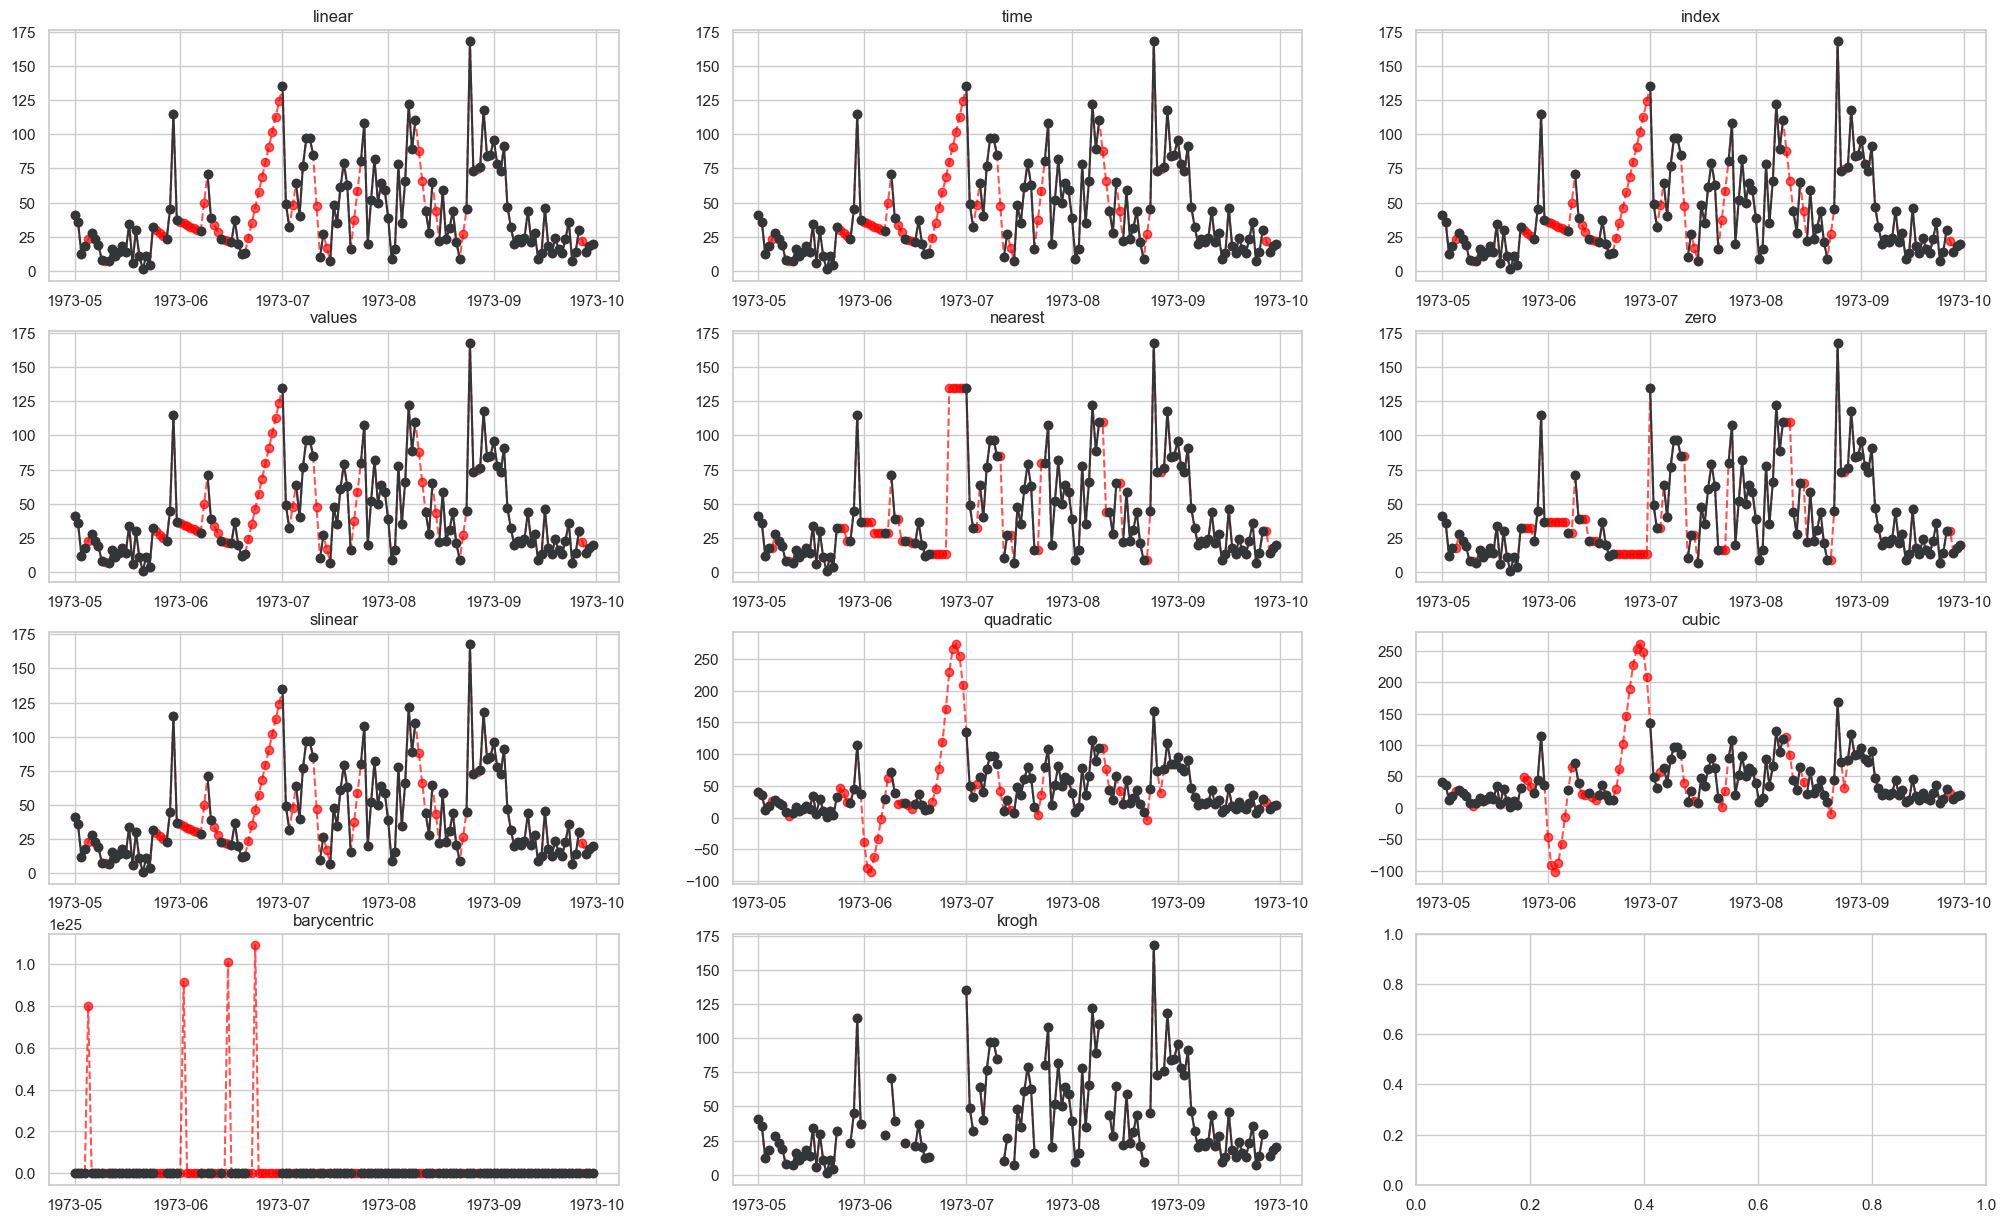

In [106]:
fig, ax = plt.subplots(4, 3, figsize = (25, 15))
mode_index = 0

for i in ax:
    for j in i:
        try:
            j.plot(airquality_df["ozone"].interpolate(method = modes[mode_index]),
                color = "red", marker = "o", alpha = 6/9, linestyle = "dashed")
            j.plot(airquality_df["ozone"], color = "#313638", marker = "o")
            j.set_title(modes[mode_index])
            mode_index += 1
        except:
            pass


### KNN

K-Nearest Neigthbors es de los calgoritmos más usados. Para cada observacion con valores faltantes:

1. Encuentra otras k observaciones (donantes, vecinos) que sean mas similares a esa observacion
   
2. Reemplaza los valores faltantes con los valores agregados de los k vecinos. Si los vecinos mas cercanos tienen valores de 1 y 2, entonces el valor a imputar es el promedio de ambos que es 1.5
Para determinar cuales son los vecinos mas similares se utilizan las metricas de distancia la cual cuantifica la distancia que hay entre dos observaciones. Entre los distintos tipos de metrica de distancia tenemos:

Distancia Euclidiana: util para las variables numericas, se traza una linea recta entre dos puntos, porque se considera el camino mas corto en un espacio euclidiano, y esa distancia se utiliza como parametro para definir si se encuentra lejos o cerca de otro punto.


![image](https://static.platzi.com/media/user_upload/Untitled-a2d3e99c-99a1-418b-bb3c-1302433df5ac.jpg)

Distancia Manhattan: es muy util para variables de tipo factor (dias de la semana, condiciones como lento, rapido), se trata de la distancia absoluta que debemos recorrer para llegar del punto a al punto b.


![image](https://static.platzi.com/media/user_upload/Untitled%20%281%29-50a6a6a5-ddb6-4845-9105-637680bdac3a.jpg)

Distancia de Hamming: es util para variables categoricas, cuantifica la diferencia entre los textos.


![image](https://static.platzi.com/media/user_upload/Untitled%20%282%29-7ea33efb-716c-440c-af40-f290e2d76c7c.jpg)

Distancia de Gower: util para conjuntos de datos con variables mixtas, se define como la distancia de un vecino a otros vecinos para determinar la distancia global referente a la fila que contiene el valor faltante.


![image](https://static.platzi.com/media/user_upload/Untitled%20%283%29-7934e781-d47e-472c-b2f1-de7e0ef98423.jpg)

|Contras   |Pros   |
|---|---|
|Su escalabilidad puede ser comprometedora dependiendo del numero de variables y el tamano de las observaciones.   |Sencillo de implementar.   |
|Requiere transformaciones especiales para las variables categoricas ya que no solo estas introduciendo numeros y se necesita cuntificar estas distancias.   |Buen rendimiento con conjunto de datos pequenos.   |
|Posee sensibilidad a valores atipicos   |Excelente para datos numericos, pero tambien funciona para datos mixtos   |


In [107]:
(
    nhanes_transformed_df
)

general_health_condition  gender  height  weight  total_cholesterol  \
SEQN                                                                            
93705.0                        2.0     0.0    63.0   165.0              157.0   
93706.0                        4.0     1.0    68.0   145.0              148.0   
93707.0                        2.0     1.0     NaN     NaN              189.0   
93709.0                        NaN     0.0    62.0   200.0              176.0   
93711.0                        4.0     1.0    69.0   142.0              238.0   
...                            ...     ...     ...     ...                ...   
102949.0                       0.0     1.0    72.0   180.0              201.0   
102953.0                       1.0     1.0    65.0   218.0              182.0   
102954.0                       2.0     0.0    66.0   150.0              172.0   
102955.0                       4.0     0.0     NaN     NaN              150.0   
102956.0                       2.0     1.0    69.0   250.0              163.0   

          pulse  diabetes   age  
SEQN                             
93705.0    52.0       0.0  66.0  
93706.0    82.0       0.0  18.0  
93707.0   100.0       0.0  13.0  
93709.0    74.0       0.0  75.0  
93711.0    62.0       0.0  56.0  
...         ...       ...   ...  
102949.0   96.0       0.0  33.0  
102953.0   78.0       0.0  42.0  
102954.0   78.0       0.0  41.0  
102955.0   74.0       0.0  14.0  
102956.0   76.0       0.0  38.0  

[7157 rows x 8 columns]

In [108]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.copy(deep = True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_transformed_df).round()

nhanes_df_knn

general_health_condition  gender  height  weight  total_cholesterol  \
SEQN                                                                            
93705.0                        2.0     0.0    63.0   165.0              157.0   
93706.0                        4.0     1.0    68.0   145.0              148.0   
93707.0                        2.0     1.0    69.0   130.0              189.0   
93709.0                        2.0     0.0    62.0   200.0              176.0   
93711.0                        4.0     1.0    69.0   142.0              238.0   
...                            ...     ...     ...     ...                ...   
102949.0                       0.0     1.0    72.0   180.0              201.0   
102953.0                       1.0     1.0    65.0   218.0              182.0   
102954.0                       2.0     0.0    66.0   150.0              172.0   
102955.0                       4.0     0.0    71.0   159.0              150.0   
102956.0                       2.0     1.0    69.0   250.0              163.0   

          pulse  diabetes   age  
SEQN                             
93705.0    52.0       0.0  66.0  
93706.0    82.0       0.0  18.0  
93707.0   100.0       0.0  13.0  
93709.0    74.0       0.0  75.0  
93711.0    62.0       0.0  56.0  
...         ...       ...   ...  
102949.0   96.0       0.0  33.0  
102953.0   78.0       0.0  42.0  
102954.0   78.0       0.0  41.0  
102955.0   74.0       0.0  14.0  
102956.0   76.0       0.0  38.0  

[7157 rows x 8 columns]

<Axes: xlabel='height', ylabel='weight'>

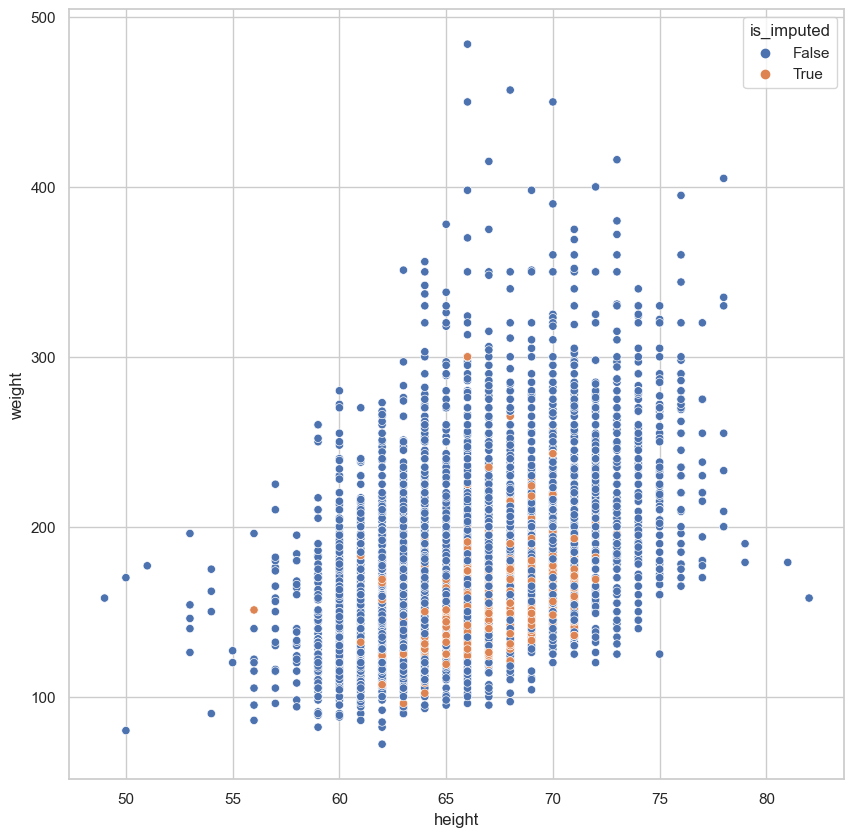

In [109]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing = True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight"
    )
)

#### Ordenamiento por cantidad de variables fatantes

In [110]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending = True).copy(deep = True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_transformed_df.missing.sort_variables_by_missingness(ascending = True)).round()

nhanes_df_knn

gender  diabetes   age  pulse  total_cholesterol  \
SEQN                                                         
93705.0      0.0       0.0  66.0   52.0              157.0   
93706.0      1.0       0.0  18.0   82.0              148.0   
93707.0      1.0       0.0  13.0  100.0              189.0   
93709.0      0.0       0.0  75.0   74.0              176.0   
93711.0      1.0       0.0  56.0   62.0              238.0   
...          ...       ...   ...    ...                ...   
102949.0     1.0       0.0  33.0   96.0              201.0   
102953.0     1.0       0.0  42.0   78.0              182.0   
102954.0     0.0       0.0  41.0   78.0              172.0   
102955.0     0.0       0.0  14.0   74.0              150.0   
102956.0     1.0       0.0  38.0   76.0              163.0   

          general_health_condition  weight  height  
SEQN                                                
93705.0                        2.0   165.0    63.0  
93706.0                        4.0   145.0    68.0  
93707.0                        2.0   130.0    69.0  
93709.0                        2.0   200.0    62.0  
93711.0                        4.0   142.0    69.0  
...                            ...     ...     ...  
102949.0                       0.0   180.0    72.0  
102953.0                       1.0   218.0    65.0  
102954.0                       2.0   150.0    66.0  
102955.0                       4.0   159.0    71.0  
102956.0                       2.0   250.0    69.0  

[7157 rows x 8 columns]

<Axes: xlabel='height', ylabel='weight'>

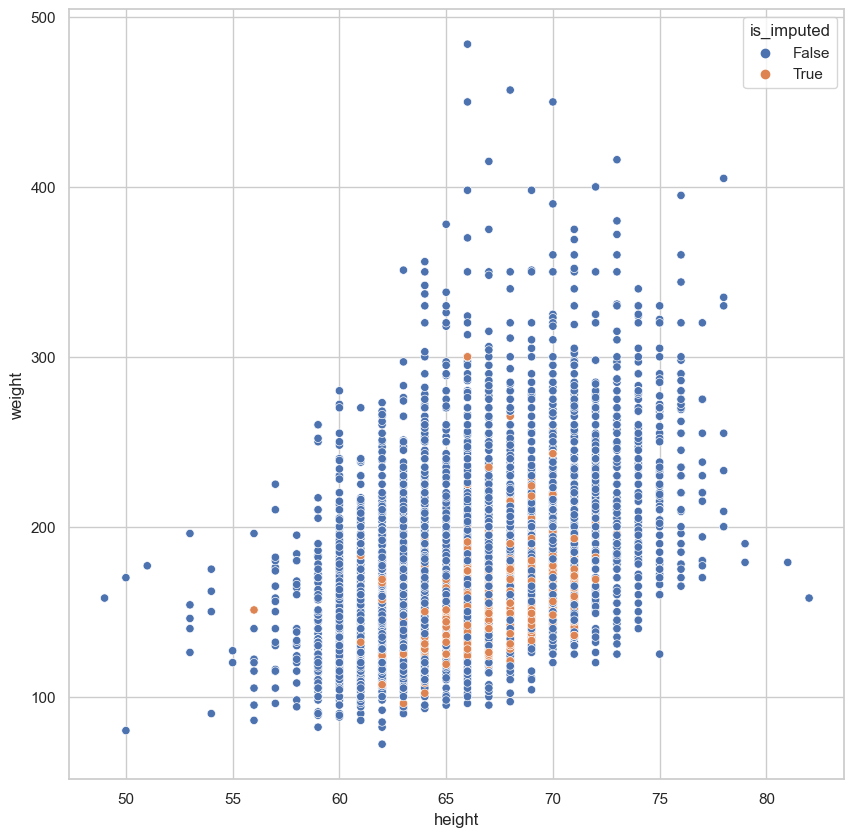

In [111]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing = True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight"
    )
)

### Basada en modelos

| Contras  |Pros   |
|---|---|
|Puede subestimar la varianza   |Mejora sobre la imputación basada en donante sencilla   |
|Los modelos funcionan mal si las variables observadas y faltantes son independientes   |Gran variedad de opciones para imputar |
|Más complicado que la imputación basada en donantes   | Preservación de relaciones entre variables  |


In [112]:
nhanes_model_df = (
    nhanes_df
    .select_columns("height", "weight", "gender", "age")
    .sort_values("height") # variable que vamos a predecir
    .transform_column(  
        'weight',   # variable con dummies
        lambda x: x.ffill(),
        elementwise = False
    )   #   matriz de sombra con el sufijo imp
    .missing.bind_shadow_matrix(
        True,
        False,
        suffix='_imp',
        only_missing=False   # matriz de sombra para todas las variables
    )
)
nhanes_model_df

height  weight  gender   age  height_imp  weight_imp  gender_imp  \
SEQN                                                                         
94940.0     49.0   158.0  Female  80.0       False       False       False   
96508.0     50.0   170.0  Female  46.0       False       False       False   
97877.0     50.0    80.0  Female  29.0       False       False       False   
102379.0    51.0   177.0  Female  71.0       False       False       False   
93816.0     53.0   146.0  Female  80.0       False       False       False   
...          ...     ...     ...   ...         ...         ...         ...   
102915.0     NaN   107.0  Female  14.0        True       False       False   
102926.0     NaN   107.0  Female  15.0        True       False       False   
102941.0     NaN   107.0  Female  14.0        True       False       False   
102945.0     NaN   107.0    Male  15.0        True       False       False   
102955.0     NaN   107.0  Female  14.0        True       False       False   

          age_imp  
SEQN               
94940.0     False  
96508.0     False  
97877.0     False  
102379.0    False  
93816.0     False  
...           ...  
102915.0    False  
102926.0    False  
102941.0    False  
102945.0    False  
102955.0    False  

[7157 rows x 8 columns]

In [113]:
height_ols = (
    nhanes_model_df
    .pipe(
        lambda df: smf.ols("height ~ weight + gender + age", df)
    )
    .fit()
)

In [114]:
ols_imputed_values = (
    nhanes_model_df
    .pipe(
        lambda df: df[df.height.isna()] # Filtrar solo los nulos
    )
    # aplicamos el modelo. Los valores imputados se redondean debido a que son enteros
    .pipe( 
    lambda df: height_ols.predict(df).round() # Predecir los valores
    )
)

ols_imputed_values

SEQN
93707.0     69.0
93719.0     64.0
93733.0     64.0
93736.0     69.0
93737.0     69.0
            ... 
102915.0    63.0
102926.0    63.0
102941.0    63.0
102945.0    68.0
102955.0    63.0
Length: 1669, dtype: float64

In [115]:
nhanes_model_df.loc[nhanes_model_df.height.isna(), ['height']]

height
SEQN            
93707.0      NaN
93719.0      NaN
93733.0      NaN
93736.0      NaN
93737.0      NaN
...          ...
102915.0     NaN
102926.0     NaN
102941.0     NaN
102945.0     NaN
102955.0     NaN

[1669 rows x 1 columns]

In [116]:
# sustituimos los valores imputados generados con 
# el modelo en la variable asociada

nhanes_model_df.loc[nhanes_model_df.height.isna(), ['height']] = ols_imputed_values

nhanes_model_df

height  weight  gender   age  height_imp  weight_imp  gender_imp  \
SEQN                                                                         
94940.0     49.0   158.0  Female  80.0       False       False       False   
96508.0     50.0   170.0  Female  46.0       False       False       False   
97877.0     50.0    80.0  Female  29.0       False       False       False   
102379.0    51.0   177.0  Female  71.0       False       False       False   
93816.0     53.0   146.0  Female  80.0       False       False       False   
...          ...     ...     ...   ...         ...         ...         ...   
102915.0    63.0   107.0  Female  14.0        True       False       False   
102926.0    63.0   107.0  Female  15.0        True       False       False   
102941.0    63.0   107.0  Female  14.0        True       False       False   
102945.0    68.0   107.0    Male  15.0        True       False       False   
102955.0    63.0   107.0  Female  14.0        True       False       False   

          age_imp  
SEQN               
94940.0     False  
96508.0     False  
97877.0     False  
102379.0    False  
93816.0     False  
...           ...  
102915.0    False  
102926.0    False  
102941.0    False  
102945.0    False  
102955.0    False  

[7157 rows x 8 columns]

<Axes: xlabel='weight', ylabel='height'>

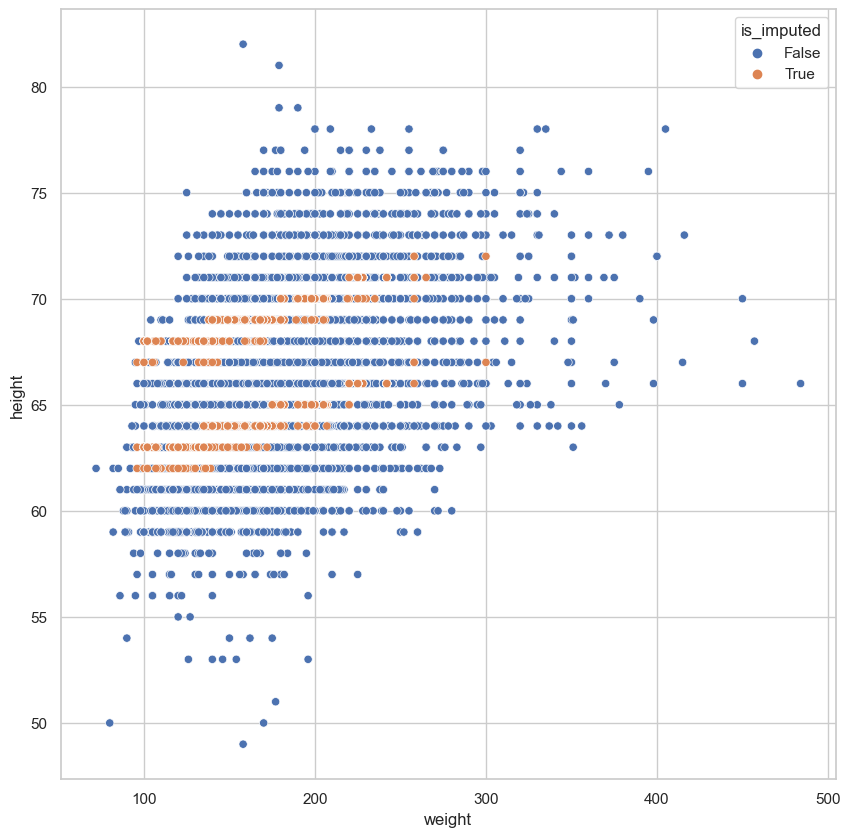

In [117]:
(
    nhanes_model_df
    .missing
    .scatter_imputation_plot(
        x = 'weight',   # variable independiente
        y = 'height'    # variable objetivo
    )
)


#### Ecuaciones encadenadas (MICE)

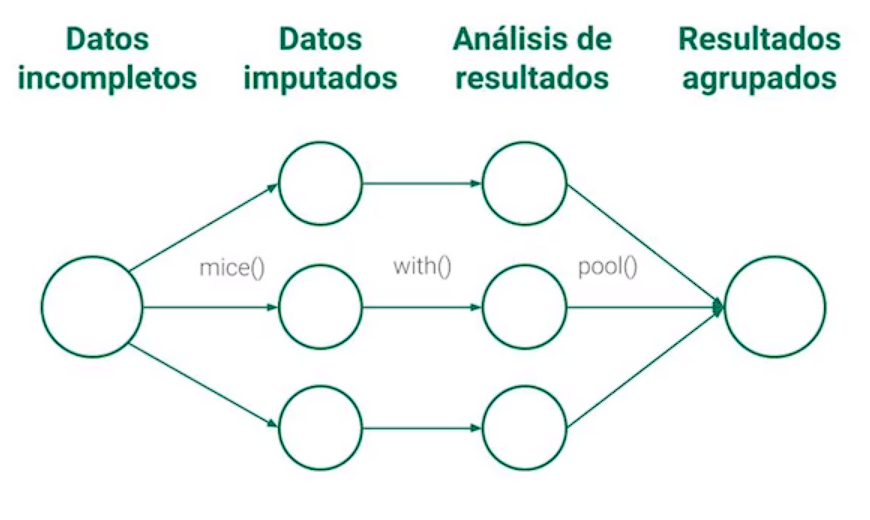

|Contras   |Pros   |
|---|---|
|Para funcionar bien necesitas pensar en el modelo de imputación y el modelo de análisis   |Mantiene la distribución relativa similar antes y después de la imputación   |
|Solo funciona como los métodos de imputación seleccionados   |Puede ser usada para cualquier tipo de analisis  |
|   | Múltiples variables son imputadas  |


In [122]:
mice_imputer = sklearn.impute.IterativeImputer(
    estimator = BayesianRidge(),
    initial_strategy="mean", # Como se va a inicializar los NaN
    imputation_order="ascending"
    )

nhanes_mice_df = nhanes_transformed_df.copy(deep=True)


nhanes_mice_df.iloc[:, :] =  mice_imputer.fit_transform(nhanes_transformed_df).round()

nhanes_mice_df = pd.concat(
    [
        nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix(True, False, only_missing=False, suffix="_imp")
    ],
    axis=1
)

<Axes: xlabel='height', ylabel='weight'>

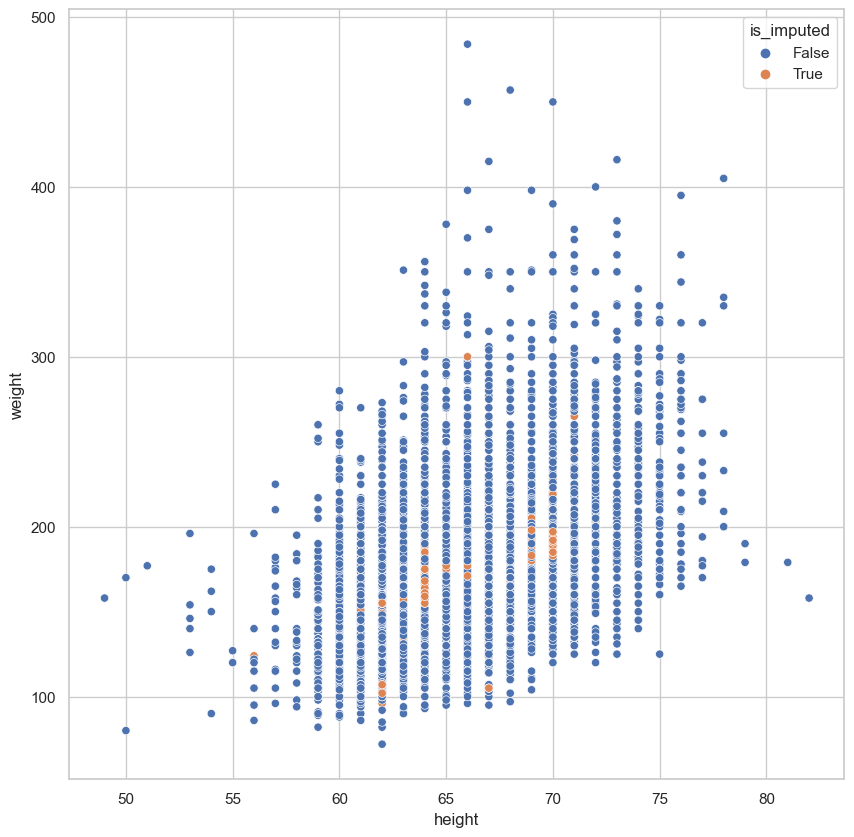

In [123]:
nhanes_mice_df.missing.scatter_imputation_plot(
    x = 'height',
    y = 'weight'
)

## Transformación inversa

In [124]:
nhanes_imputed_df = nhanes_mice_df.copy(deep=True)

In [132]:
nhanes_imputed_df[catecorical_columns] = (
    catecorical_transformer.
    named_transformers_
    ["ordinalencoder"]
    .inverse_transform(
        X = nhanes_mice_df[catecorical_columns]
    )
)

nhanes_imputed_df

general_health_condition  gender  height  weight  total_cholesterol  \
SEQN                                                                           
93705.0                      Good  Female    63.0   165.0              157.0   
93706.0                 Very good    Male    68.0   145.0              148.0   
93707.0                      Good    Male    70.0   200.0              189.0   
93709.0                      Good  Female    62.0   200.0              176.0   
93711.0                 Very good    Male    69.0   142.0              238.0   
...                           ...     ...     ...     ...                ...   
102949.0                Excellent    Male    72.0   180.0              201.0   
102953.0                  Fair or    Male    65.0   218.0              182.0   
102954.0                     Good  Female    66.0   150.0              172.0   
102955.0                Very good  Female    64.0   159.0              150.0   
102956.0                     Good    Male    69.0   250.0              163.0   

          pulse  diabetes   age  height_imp  weight_imp  \
SEQN                                                      
93705.0    52.0       0.0  66.0       False       False   
93706.0    82.0       0.0  18.0       False       False   
93707.0   100.0       0.0  13.0        True        True   
93709.0    74.0       0.0  75.0       False       False   
93711.0    62.0       0.0  56.0       False       False   
...         ...       ...   ...         ...         ...   
102949.0   96.0       0.0  33.0       False       False   
102953.0   78.0       0.0  42.0       False       False   
102954.0   78.0       0.0  41.0       False       False   
102955.0   74.0       0.0  14.0        True        True   
102956.0   76.0       0.0  38.0       False       False   

          general_health_condition_imp  total_cholesterol_imp  pulse_imp  \
SEQN                                                                       
93705.0                          False                  False      False   
93706.0                          False                  False      False   
93707.0                          False                  False      False   
93709.0                           True                  False      False   
93711.0                          False                  False      False   
...                                ...                    ...        ...   
102949.0                         False                  False      False   
102953.0                         False                  False      False   
102954.0                         False                  False      False   
102955.0                         False                  False      False   
102956.0                         False                  False      False   

          diabetes_imp  age_imp  gender_imp  
SEQN                                         
93705.0          False    False       False  
93706.0          False    False       False  
93707.0          False    False       False  
93709.0          False    False       False  
93711.0          False    False       False  
...                ...      ...         ...  
102949.0         False    False       False  
102953.0         False    False       False  
102954.0         False    False       False  
102955.0         False    False       False  
102956.0         False    False       False  

[7157 rows x 16 columns]

In [135]:
pd.DataFrame(
    dict(
        original = nhanes_df.general_health_condition.value_counts(),
        imputed = nhanes_imputed_df.general_health_condition.value_counts()
    )
)

original  imputed
general_health_condition                   
Good                          2383     3743
Very good                     1503     1503
Fair or                       1130     1130
Excellent                      612      612
Poor?                          169      169

In [136]:
nhanes_imputed_df.missing.number_missing()

0